In [5]:
import numpy as np

# 加载NPZ文件
npz_path = "/home/SENSETIME/yanzichen/Diffusion-Planner/preprocess_training_data/sg-one-north_0cc1ed4044a35a0e.npz"
data = np.load(npz_path, allow_pickle=True)

# 打印所有字段名
print("文件包含的字段：")
for key in data.keys():
    print(f"- {key}")

# 打印每个字段的形状和部分内容（示例）
print("\n各字段详细信息：")
for key in data.keys():
    arr = data[key]
    print(f"\n字段名: {key}")
    print(f"形状: {arr.shape}")
    print(f"数据类型: {arr.dtype}")
    # 打印前2个元素（避免数据量过大）
    if arr.size > 0:
        print("前2个元素示例:")
        print(arr[:2] if arr.ndim > 0 else arr)

文件包含的字段：
- map_name
- token
- ego_current_state
- ego_agent_future
- neighbor_agents_past
- neighbor_agents_future
- static_objects
- lanes
- lanes_speed_limit
- lanes_has_speed_limit
- route_lanes
- route_lanes_speed_limit
- route_lanes_has_speed_limit

各字段详细信息：

字段名: map_name
形状: ()
数据类型: <U12
前2个元素示例:
sg-one-north

字段名: token
形状: ()
数据类型: <U16
前2个元素示例:
0cc1ed4044a35a0e

字段名: ego_current_state
形状: (10,)
数据类型: float32
前2个元素示例:
[0. 0.]

字段名: ego_agent_future
形状: (80, 3)
数据类型: float32
前2个元素示例:
[[ 2.7070570e-01 -5.0810920e-03  4.5437351e-04]
 [ 5.3612548e-01 -8.7091913e-03  1.4120192e-03]]

字段名: neighbor_agents_past
形状: (32, 21, 11)
数据类型: float32
前2个元素示例:
[[[ 2.99279499e+01 -6.43578482e+00 -2.52232462e-01  9.67666686e-01
   -1.60076380e+00  6.14640522e+00  9.38235164e-01  2.10661817e+00
    0.00000000e+00  0.00000000e+00  1.00000000e+00]
  [ 2.97640381e+01 -5.85319901e+00 -2.57299006e-01  9.66331840e-01
   -1.62611616e+00  6.00196314e+00  9.37697709e-01  2.10792351e+00
    0.00000000e+00

In [17]:
import torch
import json
import numpy as np
from pathlib import Path

# 导入模型和配置类
from diffusion_planner.model.diffusion_planner import Diffusion_Planner
from diffusion_planner.utils.config import Config

def load_model(args_file, ckpt_file, device, dtype=torch.float64):  # 新增dtype参数，默认double
    """加载模型和配置，并设置模型数据类型"""
    with open(args_file, 'r') as f:
        args = json.load(f)
    
    guidance_fn = None
    config = Config(args_file, guidance_fn)
    model = Diffusion_Planner(config)

    # 加载并处理权重
    ckpt = torch.load(ckpt_file, map_location=device)
    if 'model' in ckpt:
        state_dict = ckpt['model']
    elif 'state_dict' in ckpt:
        state_dict = ckpt['state_dict']
    else:
        state_dict = ckpt
    
    new_state_dict = {k[len('module.'): ] if k.startswith('module.') else k: v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict)
    
    # 转换模型到目标设备和数据类型
    model = model.to(device, dtype=dtype).eval()
    return model, args

def load_npz_data(npz_path, config, device, dtype=torch.float64):  # 新增dtype参数
    """加载NPZ数据，转换为模型所需的输入格式和类型"""
    data = np.load(npz_path, allow_pickle=True)
    print(f"成功加载NPZ文件，包含字段: {list(data.keys())}")

    # 提取自车历史状态
    ego_agent_past = data.get(
        "ego_agent_past", 
        np.zeros((config["time_len"], config["agent_state_dim"]), dtype=np.float64)  # 用64位浮点
    )

    # 解析核心字段
    parsed_data = {
        "neighbor_agents_past": data.get(
            "neighbor_agents_past", 
            np.zeros((3, config["time_len"], config["agent_state_dim"]), dtype=np.float64)
        ),
        "static_objects": data.get(
            "static_objects", 
            np.zeros((config["static_objects_num"], config["static_objects_state_dim"]), dtype=np.float64)
        ),
        "lanes": data.get(
            "lanes", 
            np.zeros((config["lane_num"], config["lane_len"], config["lane_state_dim"]), dtype=np.float64)
        ),
        "lanes_speed_limit": data.get(
            "lanes_speed_limit", 
            np.full(config["lane_num"], 30.0, dtype=np.float64)
        ),
        "lanes_has_speed_limit": data.get(
            "lanes_has_speed_limit", 
            np.zeros(config["lane_num"], dtype=bool)
        ),
        "ego_agent_past": ego_agent_past,
        "ego_current_state": data.get(
            "ego_current_state", 
            ego_agent_past[-1:] if len(ego_agent_past) > 0 else 
            np.zeros((1, config["agent_state_dim"]), dtype=np.float64)
        ),
        "start": data.get(
            "start", 
            np.array([[0.0, 0.0]], dtype=np.float64)
        ),
        "goal": data.get(
            "goal", 
            np.array([[10.0, 10.0]], dtype=np.float64)
        ),
        "route_lanes": data.get(
            "route_lanes", 
            np.zeros((config["route_num"], config["route_len"], 2), dtype=np.float64)
        )
    }

    # 适配模型维度要求
    batch_data = {}
    for key, value in parsed_data.items():
        # 转换为torch张量（注意数据类型）
        if key == "lanes_has_speed_limit":
            tensor = torch.tensor(value, dtype=torch.bool, device=device)
        else:
            tensor = torch.tensor(value, dtype=dtype, device=device)  # 使用指定的dtype
        
        # 补充batch维度
        if len(tensor.shape) >= 1:
            tensor = tensor.unsqueeze(0)  # [batch=1, ...]
        
        # 坐标字段扩展为3D（x, y, z）
        if key in ["lanes", "start", "goal", "route_lanes"] and tensor.shape[-1] == 2:
            z = torch.zeros_like(tensor[..., :1], dtype=dtype)  # 确保z的类型一致
            tensor = torch.cat([tensor, z], dim=-1)
        
        batch_data[key] = tensor

    # 确保邻居代理数量符合要求
    num_neighbors = batch_data["neighbor_agents_past"].shape[1]
    max_agents = config["agent_num"]
    if num_neighbors > max_agents:
        batch_data["neighbor_agents_past"] = batch_data["neighbor_agents_past"][:, :max_agents, ...]
    elif num_neighbors < max_agents:
        pad = torch.zeros(
            1, max_agents - num_neighbors, *batch_data["neighbor_agents_past"].shape[2:], 
            device=device, dtype=dtype  # 确保pad的类型一致
        )
        batch_data["neighbor_agents_past"] = torch.cat([batch_data["neighbor_agents_past"], pad], dim=1)

    # 打印关键字段信息（包含数据类型）
    print("\n解析后的数据维度和类型：")
    for key in ["ego_current_state", "lanes_has_speed_limit", "lanes", "route_lanes"]:
        print(f"{key}: 形状={batch_data[key].shape}, 类型={batch_data[key].dtype}")

    return batch_data

def main():
    # 设备配置（4090 GPU）
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    dtype = torch.float32  # 改为float32
    print(f"使用设备: {device}, 数据类型: {dtype}")

    # 验证GPU是否可用
    if device.type == "cuda":
        print(f"GPU名称: {torch.cuda.get_device_name(0)}")
        print(f"CUDA版本: {torch.version.cuda}")
    else:
        print("警告: 未检测到可用GPU，将使用CPU进行推理")

    # 文件路径
    npz_path = "/home/SENSETIME/yanzichen/Diffusion-Planner/preprocess_training_data/sg-one-north_0cc1ed4044a35a0e.npz"
    args_file = "/home/SENSETIME/yanzichen/Diffusion-Planner/checkpoints/args.json"
    ckpt_file = "/home/SENSETIME/yanzichen/Diffusion-Planner/checkpoints/model.pth"
    
    # 验证文件存在性
    if not Path(npz_path).exists():
        print(f"错误：NPZ文件不存在 - {npz_path}")
        return
    if not Path(args_file).exists():
        print(f"错误：配置文件不存在 - {args_file}")
        return
    if not Path(ckpt_file).exists():
        print(f"错误：模型权重文件不存在 - {ckpt_file}")
        return
    
    # 加载模型和配置（指定dtype）
    print("加载模型和配置...")
    model, config = load_model(args_file, ckpt_file, device, dtype)
    print(f"模型配置: {json.dumps(config, indent=2)[:500]}...")
    
    # 加载并解析NPZ数据（指定dtype）
    print("加载NPZ数据...")
    input_data = load_npz_data(npz_path, config, device, dtype)
    
    # 推理
    print("\n开始推理...")
    with torch.no_grad():
        try:
            outputs = model(input_data)
            # 处理模型输出
            if isinstance(outputs, tuple):
                decoder_outputs = outputs[-1]
            else:
                decoder_outputs = outputs
        except KeyError as e:
            print(f"推理失败：输入数据缺少字段 - {e}")
            return
        except Exception as e:
            print(f"推理失败：{str(e)}")
            import traceback
            traceback.print_exc()
            return
    
    # 处理输出（转换为float32方便后续处理）
    print("\n推理成功！")
    future_len = config["future_len"]
    plan = decoder_outputs.cpu().numpy().astype(np.float32)  # 转为float32
    
    print(f"规划路径形状: {plan.shape}")
    if plan.ndim >= 2 and plan.shape[1] == future_len:
        print(f"规划路径长度: {future_len}（与配置一致）")
        print("\n前10步规划路径 (x, y):")
        for i in range(min(10, future_len)):
            x, y = plan[0, i, :2]
            print(f"第{i}步: ({x:.2f}, {y:.2f})")
    else:
        print("输出维度说明：")
        print("可能需要根据模型实际输出调整解析逻辑")
        print(f"输出维度: {plan.shape}")

if __name__ == "__main__":
    main()

使用设备: cuda:0, 数据类型: torch.float32
GPU名称: NVIDIA GeForce RTX 4060
CUDA版本: 11.1
加载模型和配置...
模型配置: {
  "future_len": 80,
  "time_len": 21,
  "agent_state_dim": 11,
  "agent_num": 32,
  "static_objects_state_dim": 10,
  "static_objects_num": 5,
  "lane_len": 20,
  "lane_state_dim": 12,
  "lane_num": 70,
  "map_len": 10,
  "map_state_dim": 4,
  "map_num": 5,
  "route_len": 20,
  "route_state_dim": 12,
  "route_num": 25,
  "encoder_drop_path_rate": 0.1,
  "decoder_drop_path_rate": 0.1,
  "device": "cuda",
  "encoder_depth": 3,
  "decoder_depth": 3,
  "num_heads": 6,
  "hidden_dim": 192,
  "diffu...
加载NPZ数据...
成功加载NPZ文件，包含字段: ['map_name', 'token', 'ego_current_state', 'ego_agent_future', 'neighbor_agents_past', 'neighbor_agents_future', 'static_objects', 'lanes', 'lanes_speed_limit', 'lanes_has_speed_limit', 'route_lanes', 'route_lanes_speed_limit', 'route_lanes_has_speed_limit']

解析后的数据维度和类型：
ego_current_state: 形状=torch.Size([1, 10]), 类型=torch.float32
lanes_has_speed_limit: 形状=torch.Size([1, 

Traceback (most recent call last):
  File "/tmp/ipykernel_20095/4136014427.py", line 169, in main
    outputs = model(input_data)
  File "/home/SENSETIME/yanzichen/anaconda3/envs/nuplan/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1051, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/SENSETIME/yanzichen/Diffusion-Planner/diffusion_planner/model/diffusion_planner.py", line 23, in forward
    decoder_outputs = self.decoder(encoder_outputs, inputs)
  File "/home/SENSETIME/yanzichen/anaconda3/envs/nuplan/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1051, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/SENSETIME/yanzichen/Diffusion-Planner/diffusion_planner/model/diffusion_planner.py", line 100, in forward
    decoder_outputs = self.decoder(encoder_outputs, inputs)
  File "/home/SENSETIME/yanzichen/anaconda3/envs/nuplan/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1051, in _call_impl
    return fo

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# LoRA组件
class LoRALayer(nn.Module):
    def __init__(self, in_dim, out_dim, rank=8, alpha=32.0):
        super().__init__()
        self.rank = rank
        self.alpha = alpha
        self.A = nn.Parameter(torch.zeros(in_dim, rank))
        self.B = nn.Parameter(torch.zeros(rank, out_dim))
        nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        nn.init.zeros_(self.B)  # Explicit zero initialization
        self.scaling = self.alpha / self.rank

    def forward(self, x):
        return (x @ self.A @ self.B) * self.scaling

class LoRALinear(nn.Module):
    def __init__(self, linear, rank=8, alpha=32.0):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(linear.in_features, linear.out_features, rank, alpha)
        
        # Freeze the original weights
        for param in self.linear.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.linear(x) + self.lora(x)

def apply_lora_to_model(model, rank=8, alpha=32.0):
    for name, module in model.named_children():
        if isinstance(module, nn.Linear):
            setattr(model, name, LoRALinear(module, rank, alpha))
        else:
            apply_lora_to_model(module, rank, alpha)
    return model

# MMoE组件
class Expert(nn.Module):
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()
        self.fc = nn.Sequential(
            LoRALinear(nn.Linear(input_dim, hidden_dim)),
            nn.GELU(),
            LoRALinear(nn.Linear(hidden_dim, hidden_dim)),
            nn.GELU()
        )

    def forward(self, x):
        return self.fc(x)

class GateNetwork(nn.Module):
    def __init__(self, input_dim, num_experts):
        super().__init__()
        self.gate = nn.Linear(input_dim, num_experts)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        return self.softmax(self.gate(x))

class MMoE6(nn.Module):
    def __init__(self, feature_dim, hidden_dim=256, num_experts=6, num_tasks=6):
        super().__init__()
        self.experts = nn.ModuleList([Expert(feature_dim, hidden_dim) for _ in range(num_experts)])
        self.gates = nn.ModuleList([GateNetwork(feature_dim, num_experts) for _ in range(num_tasks)])
        self.num_experts = num_experts
        self.num_tasks = num_tasks

    def forward(self, x):
        expert_outputs = [self.experts[i](x) for i in range(self.num_experts)]
        expert_outputs = torch.stack(expert_outputs, dim=1)  # [batch_size, num_experts, hidden_dim]
        
        task_outputs = []
        for i in range(self.num_tasks):
            gates = self.gates[i](x).unsqueeze(2)  # [batch_size, num_experts, 1]
            task_output = torch.sum(expert_outputs * gates, dim=1)  # [batch_size, hidden_dim]
            task_outputs.append(task_output)
            
        return task_outputs

In [5]:
def test_lora_layer():
    # Test parameters
    batch_size = 4
    in_dim = 128
    out_dim = 256
    rank = 8
    
    # Create layer
    lora_layer = LoRALayer(in_dim, out_dim, rank)
    
    # Test initialization
    assert lora_layer.A.shape == (in_dim, rank), "A matrix has wrong shape"
    assert lora_layer.B.shape == (rank, out_dim), "B matrix has wrong shape"
    assert not torch.allclose(lora_layer.A, torch.zeros_like(lora_layer.A)), "A matrix not initialized"
    assert torch.allclose(lora_layer.B, torch.zeros_like(lora_layer.B)), "B matrix should be zero-initialized"
    
    # Test forward pass
    x = torch.randn(batch_size, in_dim)
    output = lora_layer(x)
    assert output.shape == (batch_size, out_dim), "Output shape incorrect"
    
    print("LoRALayer test passed!")

def test_lora_linear():
    # Test parameters
    batch_size = 4
    in_dim = 128
    out_dim = 256
    
    # Create original linear layer and LoRA wrapper
    linear = nn.Linear(in_dim, out_dim)
    original_weight = linear.weight.detach().clone()
    original_bias = linear.bias.detach().clone()
    
    lora_linear = LoRALinear(linear)
    
    # Verify original weights are frozen
    assert not linear.weight.requires_grad, "Original weights should be frozen"
    assert not linear.bias.requires_grad, "Original bias should be frozen"
    
    # Test forward pass
    x = torch.randn(batch_size, in_dim)
    original_output = linear(x)
    lora_output = lora_linear(x)
    
    assert lora_output.shape == original_output.shape, "Output shapes should match"
    
    # After one forward pass, outputs should be different because:
    # 1. A is randomly initialized (non-zero)
    # 2. B is zero, but A@B is not exactly zero due to numerical computation
    # So we'll check if weights are being properly applied
    
    # Verify the original linear layer weights haven't changed
    assert torch.allclose(linear.weight, original_weight), "Original weights should not change"
    assert torch.allclose(linear.bias, original_bias), "Original bias should not change"
    
    # Verify LoRA parameters are trainable
    assert lora_linear.lora.A.requires_grad, "LoRA A should be trainable"
    assert lora_linear.lora.B.requires_grad, "LoRA B should be trainable"
    
    print("LoRALinear test passed!")

In [6]:
def test_expert():
    # Test parameters
    batch_size = 4
    input_dim = 128
    hidden_dim = 256
    
    # Create expert with LoRA
    expert = Expert(input_dim, hidden_dim)
    
    # Verify architecture
    assert len(expert.fc) == 4, "Expert should have 4 layers"
    assert isinstance(expert.fc[0], LoRALinear), "First layer should be LoRALinear"
    assert isinstance(expert.fc[2], LoRALinear), "Third layer should be LoRALinear"
    
    # Test forward pass
    x = torch.randn(batch_size, input_dim)
    output = expert(x)
    assert output.shape == (batch_size, hidden_dim), "Output shape incorrect"
    
    print("Expert test passed!")

In [7]:
def test_gate_network():
    # Test parameters
    batch_size = 4
    input_dim = 128
    num_experts = 6
    
    # Create gate network
    gate = GateNetwork(input_dim, num_experts)
    
    # Test forward pass
    x = torch.randn(batch_size, input_dim)
    output = gate(x)
    
    assert output.shape == (batch_size, num_experts), "Output shape incorrect"
    assert torch.allclose(output.sum(dim=1), torch.ones(batch_size)), "Output should sum to 1"
    
    print("GateNetwork test passed!")

In [8]:
def test_mmoe6_integration():
    # Test parameters
    batch_size = 4
    feature_dim = 128
    hidden_dim = 256
    num_experts = 6
    num_tasks = 6
    
    # Create and apply LoRA
    model = MMoE6(feature_dim, hidden_dim, num_experts, num_tasks)
    model = apply_lora_to_model(model)
    
    # Verify architecture
    assert len(model.experts) == num_experts, "Wrong number of experts"
    assert len(model.gates) == num_tasks, "Wrong number of gates"
    
    # Check LoRA application
    for expert in model.experts:
        assert isinstance(expert.fc[0], LoRALinear), "Experts should have LoRA layers"
        assert isinstance(expert.fc[2], LoRALinear), "Experts should have LoRA layers"
    
    # Test forward pass
    x = torch.randn(batch_size, feature_dim)
    task_outputs = model(x)
    
    # Verify outputs
    assert len(task_outputs) == num_tasks, "Number of task outputs should match num_tasks"
    for output in task_outputs:
        assert output.shape == (batch_size, hidden_dim), f"Output shape should be ({batch_size}, {hidden_dim})"
    
    print("MMoE6 integration test passed!")

In [9]:
if __name__ == "__main__":
    print("Running component tests...")
    test_lora_layer()
    test_lora_linear()
    test_expert()
    test_gate_network()
    test_mmoe6_integration()
    print("All tests passed successfully!")

Running component tests...
LoRALayer test passed!
LoRALinear test passed!
Expert test passed!
GateNetwork test passed!
MMoE6 integration test passed!
All tests passed successfully!


In [10]:
def test_mmoe6_with_lora():
    # Test parameters
    batch_size = 4
    feature_dim = 128
    hidden_dim = 256
    num_experts = 6
    num_tasks = 6
    
    # Create model
    model = MMoE6(feature_dim, hidden_dim, num_experts, num_tasks)
    
    # Apply LoRA to all linear layers (including those inside experts)
    model = apply_lora_to_model(model, rank=8, alpha=32.0)
    
    # Create test input
    x = torch.randn(batch_size, feature_dim)
    
    # Forward pass
    task_outputs = model(x)
    
    # Verify outputs
    assert len(task_outputs) == num_tasks, "Number of task outputs should match num_tasks"
    for output in task_outputs:
        assert output.shape == (batch_size, hidden_dim), f"Output shape should be ({batch_size}, {hidden_dim})"
    
    print("Test passed! All outputs have the correct shape.")

# Run the test
test_mmoe6_with_lora()

Test passed! All outputs have the correct shape.


In [11]:
def prepare_datasets() -> Tuple[DataLoader, DataLoader]:
    """准备混合数据集（20% nuPlan + 80% 实车数据）"""
    # 导入必要的模块
    from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
    import torch
    import numpy as np
    
    class SimulatedDataset(Dataset):
        def __init__(self, size=1000, feature_dim=512, num_classes=6):
            self.size = size
            self.feature_dim = feature_dim
            self.num_classes = num_classes
            
        def __len__(self):
            return self.size
        
        def __getitem__(self, idx):
            # 生成随机特征和标签
            features = torch.randn(self.feature_dim)
            trajectory = torch.randn(2)  # 假设输出是二维轨迹点
            scene_label = torch.randint(0, self.num_classes, (1,)).long().squeeze()
            
            return features, trajectory, scene_label

    # 创建模拟数据集
    nuplan_dataset = SimulatedDataset(size=1000, feature_dim=512, num_classes=6)
    realworld_dataset = SimulatedDataset(size=4000, feature_dim=512, num_classes=6)

    # 计算混合比例
    nuplan_size = len(nuplan_dataset)
    realworld_size = len(realworld_dataset)
    total_size = nuplan_size + realworld_size

    # 按20:80比例采样
    nuplan_samples = int(total_size * 0.2)
    realworld_samples = int(total_size * 0.8)

    # 创建采样器
    nuplan_indices = torch.randperm(len(nuplan_dataset))[:nuplan_samples]
    realworld_indices = torch.randperm(len(realworld_dataset))[:realworld_samples]

    nuplan_subset = Subset(nuplan_dataset, nuplan_indices)
    realworld_subset = Subset(realworld_dataset, realworld_indices)

    # 合并数据集
    mixed_dataset = ConcatDataset([nuplan_subset, realworld_subset])

    # 创建数据加载器
    train_loader = DataLoader(
        mixed_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=0,  # 使用0个worker以避免潜在问题
        pin_memory=False  # 如果没有GPU可以设置为False
    )

    # 准备验证集
    val_dataset = SimulatedDataset(size=1000, feature_dim=512, num_classes=6)

    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=0,
        pin_memory=False
    )

    return train_loader, val_loader

NameError: name 'Tuple' is not defined

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset

from diffusion_planner.utils.data_augmentation import StatePerturbation   
from diffusion_planner.utils.train_utils import get_epoch_mean_loss
from diffusion_planner.utils import ddp
from diffusion_planner.loss import diffusion_loss_func


# 配置参数
BRANCH_NAME = "diffusion_planner_release"
ARGS_FILE = "/home/SENSETIME/yanzichen/Diffusion-Planner/checkpoints/args.json"
CKPT_FILE = "/home/SENSETIME/yanzichen/Diffusion-Planner/checkpoints/model.pth"
OUTPUT_DIR = f"/home/SENSETIME/yanzichen/Diffusion-Planner/checkpoints/{BRANCH_NAME}"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 创建输出目录
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_base_model() -> nn.Module:
    """加载预训练的Diffusion Planner基模型"""
    # 加载配置参数
    with open(ARGS_FILE, 'r') as f:
        args = json.load(f)
    
    # 导入模型类（根据实际项目结构调整）
    from diffusion_planner.model.diffusion_planner import DiffusionPlanner
    
    # 初始化模型
    model = DiffusionPlanner(
        input_dim=args['input_dim'],
        hidden_dim=args['hidden_dim'],
        num_layers=args['num_layers'],
        diffusion_steps=args['diffusion_steps']
    )
    
    # 加载预训练权重
    checkpoint = torch.load(CKPT_FILE, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded base model from {CKPT_FILE}")
    
    return model

def setup_mmoe_lora(base_model: nn.Module, feature_dim: int) -> nn.Module:
    """配置MMoE-6专家网络和LoRA适配器"""
    # 冻结基模型参数
    for param in base_model.parameters():
        param.requires_grad = False
    
    # 应用LoRA到基模型的线性层
    base_model = apply_lora_to_model(base_model, rank=10, alpha=32.0)
    
    # 添加MMoE-6专家网络
    class DiffusionPlannerWithMMoE(nn.Module):
        def __init__(self, base_model, feature_dim):
            super().__init__()
            self.base_model = base_model
            self.mmoe = MMoE6(feature_dim=feature_dim, hidden_dim=256, num_experts=6, num_tasks=6)
            
            # 场景分类器
            self.scene_classifier = nn.Sequential(
                nn.Linear(feature_dim, 256),
                nn.GELU(),
                nn.Linear(256, 6),  # 6类场景
                nn.Softmax(dim=1)
            )
            
            # 任务特定输出头
            self.task_heads = nn.ModuleList([
                nn.Sequential(
                    LoRALinear(nn.Linear(256, 256), rank=10),
                    nn.GELU(),
                    LoRALinear(nn.Linear(256, 2), rank=10)  # 输出轨迹点(x,y)
                ) for _ in range(6)  # 6类场景
            ])
            
            # 场景名称映射
            self.scene_names = ["普通巡航", "坡道", "弯道", "绕障", "会车", "横穿"]
        
        def forward(self, x, t=None):
            # 提取特征（根据实际模型调整）
            if hasattr(self.base_model, 'extract_features'):
                features = self.base_model.extract_features(x, t)
            else:
                # 如果模型没有extract_features方法，使用forward的中间输出
                with torch.no_grad():
                    base_output = self.base_model(x, t)
                features = base_output['features'] if isinstance(base_output, dict) else base_output
            
            # 场景分类
            scene_probs = self.scene_classifier(features)
            scene_id = torch.argmax(scene_probs, dim=1)
            
            # MMoE处理
            mmoe_outputs = self.mmoe(features)
            
            # 根据场景选择输出头
            batch_size = x.size(0)
            outputs = torch.zeros(batch_size, 2, device=x.device)
            
            for i in range(6):
                mask = (scene_id == i).unsqueeze(1).expand(-1, 2)
                if mask.any():
                    outputs[mask] = self.task_heads[i](mmoe_outputs[i])[mask]
                    
            return {
                "trajectory": outputs,
                "scene_id": scene_id,
                "scene_probs": scene_probs,
                "features": features
            }
    
    # 初始化增强模型
    enhanced_model = DiffusionPlannerWithMMoE(base_model, feature_dim)
    return enhanced_model

def prepare_datasets() -> Tuple[DataLoader, DataLoader]:
    """准备混合数据集（20% nuPlan + 80% 实车数据）"""
    # 导入数据集类（根据实际项目结构调整）
    from diffusion_planner.data.nuplan_dataset import NuPlanDataset
    from diffusion_planner.data.real_world_dataset import RealWorldDataset
    
    # 创建数据集
    nuplan_dataset = NuPlanDataset(
        data_dir="/path/to/nuplan",
        split="train",
        scene_types=["cruise", "ramp", "curve", "obstacle", "meeting", "crossing"]
    )
    
    realworld_dataset = RealWorldDataset(
        data_dir="/path/to/real_world_data",
        split="train",
        scene_types=["cruise", "ramp", "curve", "obstacle", "meeting", "crossing"]
    )
    
    # 计算混合比例
    nuplan_size = len(nuplan_dataset)
    realworld_size = len(realworld_dataset)
    total_size = nuplan_size + realworld_size
    
    # 按20:80比例采样
    nuplan_samples = int(total_size * 0.2)
    realworld_samples = int(total_size * 0.8)
    
    # 创建采样器
    nuplan_indices = torch.randperm(len(nuplan_dataset))[:nuplan_samples]
    realworld_indices = torch.randperm(len(realworld_dataset))[:realworld_samples]
    
    nuplan_subset = torch.utils.data.Subset(nuplan_dataset, nuplan_indices)
    realworld_subset = torch.utils.data.Subset(realworld_dataset, realworld_indices)
    
    # 合并数据集
    mixed_dataset = ConcatDataset([nuplan_subset, realworld_subset])
    
    # 创建数据加载器
    train_loader = DataLoader(
        mixed_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=8,
        pin_memory=True
    )
    
    # 准备验证集
    val_dataset = RealWorldDataset(
        data_dir="/path/to/real_world_data",
        split="val",
        scene_types=["cruise", "ramp", "curve", "obstacle", "meeting", "crossing"]
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=8,
        pin_memory=True
    )
    
    return train_loader, val_loader

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 50,
    lr: float = 1e-4
) -> None:
    """训练增强模型"""
    # 定义优化器（只优化LoRA和MMoE参数）
    optimizer = optim.AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=lr,
        weight_decay=1e-4
    )
    
    # 定义损失函数
    criterion = diffusion_loss_func  # 使用项目中的扩散损失函数
    
    # 学习率调度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    # 训练循环
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        
        for batch_idx, (inputs, targets, scene_labels) in enumerate(train_loader):
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            scene_labels = scene_labels.to(DEVICE)
            
            # 前向传播
            optimizer.zero_grad()
            outputs = model(inputs)
            trajectory = outputs["trajectory"]
            
            # 计算损失
            loss = criterion(outputs, targets)  # 使用项目中的损失计算方式
            
            # 反向传播
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        scene_correct = 0
        scene_total = 0
        
        with torch.no_grad():
            for inputs, targets, scene_labels in val_loader:
                inputs = inputs.to(DEVICE)
                targets = targets.to(DEVICE)
                scene_labels = scene_labels.to(DEVICE)
                
                outputs = model(inputs)
                trajectory = outputs["trajectory"]
                scene_preds = outputs["scene_id"]
                
                # 计算损失
                val_loss += criterion(outputs, targets).item()
                
                # 计算场景分类准确率
                scene_total += scene_labels.size(0)
                scene_correct += (scene_preds == scene_labels).sum().item()
        
        # 计算平均损失和准确率
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        scene_acc = 100.0 * scene_correct / scene_total
        
        # 打印统计信息
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Scene Acc: {scene_acc:.2f}%")
        
        # 调整学习率
        scheduler.step(val_loss)
        
        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'scene_acc': scene_acc
            }, f"{OUTPUT_DIR}/best_model.pth")
            print(f"Saved best model with val loss: {val_loss:.4f}")

def main():
    """主函数"""
    # 设置随机种子
    torch.manual_seed(42)
    
    # 初始化分布式训练（如果需要）
    if torch.cuda.device_count() > 1:
        ddp.init_distributed_mode()
    
    # 加载基模型
    base_model = load_base_model()
    base_model = base_model.to(DEVICE)
    
    # 设置MMoE和LoRA
    feature_dim = 512  # 根据实际模型调整
    enhanced_model = setup_mmoe_lora(base_model, feature_dim)
    enhanced_model = enhanced_model.to(DEVICE)
    
    # 准备数据集
    train_loader, val_loader = prepare_datasets()
    
    # 训练模型
    train_model(enhanced_model, train_loader, val_loader, num_epochs=50)
    
    print("Training completed!")

if __name__ == "__main__":
    main()

NameError: name 'Tuple' is not defined

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset

from diffusion_planner.utils.data_augmentation import StatePerturbation   
from diffusion_planner.utils.train_utils import get_epoch_mean_loss
from diffusion_planner.utils import ddp
from diffusion_planner.loss import diffusion_loss_func


# 配置参数
BRANCH_NAME = "diffusion_planner_release"
ARGS_FILE = "/home/SENSETIME/yanzichen/Diffusion-Planner/checkpoints/args.json"
CKPT_FILE = "/home/SENSETIME/yanzichen/Diffusion-Planner/checkpoints/model.pth"
OUTPUT_DIR = f"/home/SENSETIME/yanzichen/Diffusion-Planner/checkpoints/{BRANCH_NAME}"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 创建输出目录
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_base_model() -> nn.Module:
    """加载预训练的Diffusion Planner基模型"""
    # 加载配置参数
    with open(ARGS_FILE, 'r') as f:
        args = json.load(f)
    
    # 导入模型类（根据实际项目结构调整）
    from diffusion_planner.model.diffusion_planner import DiffusionPlanner
    
    # 初始化模型
    model = DiffusionPlanner(
        input_dim=args['input_dim'],
        hidden_dim=args['hidden_dim'],
        num_layers=args['num_layers'],
        diffusion_steps=args['diffusion_steps']
    )
    
    # 加载预训练权重
    checkpoint = torch.load(CKPT_FILE, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded base model from {CKPT_FILE}")
    
    return model

def setup_mmoe_lora(base_model: nn.Module, feature_dim: int) -> nn.Module:
    """配置MMoE-6专家网络和LoRA适配器"""
    # 冻结基模型参数
    for param in base_model.parameters():
        param.requires_grad = False
    
    # 应用LoRA到基模型的线性层
    base_model = apply_lora_to_model(base_model, rank=10, alpha=32.0)
    
    # 添加MMoE-6专家网络
    class DiffusionPlannerWithMMoE(nn.Module):
        def __init__(self, base_model, feature_dim):
            super().__init__()
            self.base_model = base_model
            self.mmoe = MMoE6(feature_dim=feature_dim, hidden_dim=256, num_experts=6, num_tasks=6)
            
            # 场景分类器
            self.scene_classifier = nn.Sequential(
                nn.Linear(feature_dim, 256),
                nn.GELU(),
                nn.Linear(256, 6),  # 6类场景
                nn.Softmax(dim=1)
            )
            
            # 任务特定输出头
            self.task_heads = nn.ModuleList([
                nn.Sequential(
                    LoRALinear(nn.Linear(256, 256), rank=10),
                    nn.GELU(),
                    LoRALinear(nn.Linear(256, 2), rank=10)  # 输出轨迹点(x,y)
                ) for _ in range(6)  # 6类场景
            ])
            
            # 场景名称映射
            self.scene_names = ["普通巡航", "坡道", "弯道", "绕障", "会车", "横穿"]
        
        def forward(self, x, t=None):
            # 提取特征（根据实际模型调整）
            if hasattr(self.base_model, 'extract_features'):
                features = self.base_model.extract_features(x, t)
            else:
                # 如果模型没有extract_features方法，使用forward的中间输出
                with torch.no_grad():
                    base_output = self.base_model(x, t)
                features = base_output['features'] if isinstance(base_output, dict) else base_output
            
            # 场景分类
            scene_probs = self.scene_classifier(features)
            scene_id = torch.argmax(scene_probs, dim=1)
            
            # MMoE处理
            mmoe_outputs = self.mmoe(features)
            
            # 根据场景选择输出头
            batch_size = x.size(0)
            outputs = torch.zeros(batch_size, 2, device=x.device)
            
            for i in range(6):
                mask = (scene_id == i).unsqueeze(1).expand(-1, 2)
                if mask.any():
                    outputs[mask] = self.task_heads[i](mmoe_outputs[i])[mask]
                    
            return {
                "trajectory": outputs,
                "scene_id": scene_id,
                "scene_probs": scene_probs,
                "features": features
            }
    
    # 初始化增强模型
    enhanced_model = DiffusionPlannerWithMMoE(base_model, feature_dim)
    return enhanced_model

def prepare_datasets() -> Tuple[DataLoader, DataLoader]:
    """准备混合数据集（20% nuPlan + 80% 实车数据）"""
    # 导入数据集类（根据实际项目结构调整）
    from diffusion_planner.data.nuplan_dataset import NuPlanDataset
    from diffusion_planner.data.real_world_dataset import RealWorldDataset
    
    # 创建数据集
    nuplan_dataset = NuPlanDataset(
        data_dir="/path/to/nuplan",
        split="train",
        scene_types=["cruise", "ramp", "curve", "obstacle", "meeting", "crossing"]
    )
    
    realworld_dataset = RealWorldDataset(
        data_dir="/path/to/real_world_data",
        split="train",
        scene_types=["cruise", "ramp", "curve", "obstacle", "meeting", "crossing"]
    )
    
    # 计算混合比例
    nuplan_size = len(nuplan_dataset)
    realworld_size = len(realworld_dataset)
    total_size = nuplan_size + realworld_size
    
    # 按20:80比例采样
    nuplan_samples = int(total_size * 0.2)
    realworld_samples = int(total_size * 0.8)
    
    # 创建采样器
    nuplan_indices = torch.randperm(len(nuplan_dataset))[:nuplan_samples]
    realworld_indices = torch.randperm(len(realworld_dataset))[:realworld_samples]
    
    nuplan_subset = torch.utils.data.Subset(nuplan_dataset, nuplan_indices)
    realworld_subset = torch.utils.data.Subset(realworld_dataset, realworld_indices)
    
    # 合并数据集
    mixed_dataset = ConcatDataset([nuplan_subset, realworld_subset])
    
    # 创建数据加载器
    train_loader = DataLoader(
        mixed_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=8,
        pin_memory=True
    )
    
    # 准备验证集
    val_dataset = RealWorldDataset(
        data_dir="/path/to/real_world_data",
        split="val",
        scene_types=["cruise", "ramp", "curve", "obstacle", "meeting", "crossing"]
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=8,
        pin_memory=True
    )
    
    return train_loader, val_loader

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 50,
    lr: float = 1e-4
) -> None:
    """训练增强模型"""
    # 定义优化器（只优化LoRA和MMoE参数）
    optimizer = optim.AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=lr,
        weight_decay=1e-4
    )
    
    # 定义损失函数
    criterion = diffusion_loss_func  # 使用项目中的扩散损失函数
    
    # 学习率调度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    # 训练循环
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        
        for batch_idx, (inputs, targets, scene_labels) in enumerate(train_loader):
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            scene_labels = scene_labels.to(DEVICE)
            
            # 前向传播
            optimizer.zero_grad()
            outputs = model(inputs)
            trajectory = outputs["trajectory"]
            
            # 计算损失
            loss = criterion(outputs, targets)  # 使用项目中的损失计算方式
            
            # 反向传播
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        scene_correct = 0
        scene_total = 0
        
        with torch.no_grad():
            for inputs, targets, scene_labels in val_loader:
                inputs = inputs.to(DEVICE)
                targets = targets.to(DEVICE)
                scene_labels = scene_labels.to(DEVICE)
                
                outputs = model(inputs)
                trajectory = outputs["trajectory"]
                scene_preds = outputs["scene_id"]
                
                # 计算损失
                val_loss += criterion(outputs, targets).item()
                
                # 计算场景分类准确率
                scene_total += scene_labels.size(0)
                scene_correct += (scene_preds == scene_labels).sum().item()
        
        # 计算平均损失和准确率
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        scene_acc = 100.0 * scene_correct / scene_total
        
        # 打印统计信息
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Scene Acc: {scene_acc:.2f}%")
        
        # 调整学习率
        scheduler.step(val_loss)
        
        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'scene_acc': scene_acc
            }, f"{OUTPUT_DIR}/best_model.pth")
            print(f"Saved best model with val loss: {val_loss:.4f}")

def main():
    """主函数"""
    # 设置随机种子
    torch.manual_seed(42)
    
    # 初始化分布式训练（如果需要）
    if torch.cuda.device_count() > 1:
        ddp.init_distributed_mode()
    
    # 加载基模型
    base_model = load_base_model()
    base_model = base_model.to(DEVICE)
    
    # 设置MMoE和LoRA
    feature_dim = 512  # 根据实际模型调整
    enhanced_model = setup_mmoe_lora(base_model, feature_dim)
    enhanced_model = enhanced_model.to(DEVICE)
    
    # 准备数据集
    train_loader, val_loader = prepare_datasets()
    
    # 训练模型
    train_model(enhanced_model, train_loader, val_loader, num_epochs=50)
    
    print("Training completed!")

if __name__ == "__main__":
    main()

NameError: name 'Tuple' is not defined

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset

from diffusion_planner.utils.data_augmentation import StatePerturbation   
from diffusion_planner.utils.train_utils import get_epoch_mean_loss
from diffusion_planner.utils import ddp
from diffusion_planner.loss import diffusion_loss_func


# 配置参数
BRANCH_NAME = "diffusion_planner_release"
ARGS_FILE = "/home/SENSETIME/yanzichen/Diffusion-Planner/checkpoints/args.json"
CKPT_FILE = "/home/SENSETIME/yanzichen/Diffusion-Planner/checkpoints/model.pth"
OUTPUT_DIR = f"/home/SENSETIME/yanzichen/Diffusion-Planner/checkpoints/{BRANCH_NAME}"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 创建输出目录
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_base_model() -> nn.Module:
    """加载预训练的Diffusion Planner基模型"""
    # 加载配置参数
    with open(ARGS_FILE, 'r') as f:
        args = json.load(f)
    
    # 导入模型类（根据实际项目结构调整）
    from diffusion_planner.model.diffusion_planner import DiffusionPlanner
    
    # 初始化模型
    model = DiffusionPlanner(
        input_dim=args['input_dim'],
        hidden_dim=args['hidden_dim'],
        num_layers=args['num_layers'],
        diffusion_steps=args['diffusion_steps']
    )
    
    # 加载预训练权重
    checkpoint = torch.load(CKPT_FILE, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded base model from {CKPT_FILE}")
    
    return model

def setup_mmoe_lora(base_model: nn.Module, feature_dim: int) -> nn.Module:
    """配置MMoE-6专家网络和LoRA适配器"""
    # 冻结基模型参数
    for param in base_model.parameters():
        param.requires_grad = False
    
    # 应用LoRA到基模型的线性层
    base_model = apply_lora_to_model(base_model, rank=10, alpha=32.0)
    
    # 添加MMoE-6专家网络
    class DiffusionPlannerWithMMoE(nn.Module):
        def __init__(self, base_model, feature_dim):
            super().__init__()
            self.base_model = base_model
            self.mmoe = MMoE6(feature_dim=feature_dim, hidden_dim=256, num_experts=6, num_tasks=6)
            
            # 场景分类器
            self.scene_classifier = nn.Sequential(
                nn.Linear(feature_dim, 256),
                nn.GELU(),
                nn.Linear(256, 6),  # 6类场景
                nn.Softmax(dim=1)
            )
            
            # 任务特定输出头
            self.task_heads = nn.ModuleList([
                nn.Sequential(
                    LoRALinear(nn.Linear(256, 256), rank=10),
                    nn.GELU(),
                    LoRALinear(nn.Linear(256, 2), rank=10)  # 输出轨迹点(x,y)
                ) for _ in range(6)  # 6类场景
            ])
            
            # 场景名称映射
            self.scene_names = ["普通巡航", "坡道", "弯道", "绕障", "会车", "横穿"]
        
        def forward(self, x, t=None):
            # 提取特征（根据实际模型调整）
            if hasattr(self.base_model, 'extract_features'):
                features = self.base_model.extract_features(x, t)
            else:
                # 如果模型没有extract_features方法，使用forward的中间输出
                with torch.no_grad():
                    base_output = self.base_model(x, t)
                features = base_output['features'] if isinstance(base_output, dict) else base_output
            
            # 场景分类
            scene_probs = self.scene_classifier(features)
            scene_id = torch.argmax(scene_probs, dim=1)
            
            # MMoE处理
            mmoe_outputs = self.mmoe(features)
            
            # 根据场景选择输出头
            batch_size = x.size(0)
            outputs = torch.zeros(batch_size, 2, device=x.device)
            
            for i in range(6):
                mask = (scene_id == i).unsqueeze(1).expand(-1, 2)
                if mask.any():
                    outputs[mask] = self.task_heads[i](mmoe_outputs[i])[mask]
                    
            return {
                "trajectory": outputs,
                "scene_id": scene_id,
                "scene_probs": scene_probs,
                "features": features
            }
    
    # 初始化增强模型
    enhanced_model = DiffusionPlannerWithMMoE(base_model, feature_dim)
    return enhanced_model

def prepare_datasets() -> Tuple[DataLoader, DataLoader]:
    """准备混合数据集（20% nuPlan + 80% 实车数据）"""
    # 导入数据集类（根据实际项目结构调整）
    from diffusion_planner.data.nuplan_dataset import NuPlanDataset
    from diffusion_planner.data.real_world_dataset import RealWorldDataset
    
    # 创建数据集
    nuplan_dataset = NuPlanDataset(
        data_dir="/path/to/nuplan",
        split="train",
        scene_types=["cruise", "ramp", "curve", "obstacle", "meeting", "crossing"]
    )
    
    realworld_dataset = RealWorldDataset(
        data_dir="/path/to/real_world_data",
        split="train",
        scene_types=["cruise", "ramp", "curve", "obstacle", "meeting", "crossing"]
    )
    
    # 计算混合比例
    nuplan_size = len(nuplan_dataset)
    realworld_size = len(realworld_dataset)
    total_size = nuplan_size + realworld_size
    
    # 按20:80比例采样
    nuplan_samples = int(total_size * 0.2)
    realworld_samples = int(total_size * 0.8)
    
    # 创建采样器
    nuplan_indices = torch.randperm(len(nuplan_dataset))[:nuplan_samples]
    realworld_indices = torch.randperm(len(realworld_dataset))[:realworld_samples]
    
    nuplan_subset = torch.utils.data.Subset(nuplan_dataset, nuplan_indices)
    realworld_subset = torch.utils.data.Subset(realworld_dataset, realworld_indices)
    
    # 合并数据集
    mixed_dataset = ConcatDataset([nuplan_subset, realworld_subset])
    
    # 创建数据加载器
    train_loader = DataLoader(
        mixed_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=8,
        pin_memory=True
    )
    
    # 准备验证集
    val_dataset = RealWorldDataset(
        data_dir="/path/to/real_world_data",
        split="val",
        scene_types=["cruise", "ramp", "curve", "obstacle", "meeting", "crossing"]
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=8,
        pin_memory=True
    )
    
    return train_loader, val_loader

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 50,
    lr: float = 1e-4
) -> None:
    """训练增强模型"""
    # 定义优化器（只优化LoRA和MMoE参数）
    optimizer = optim.AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=lr,
        weight_decay=1e-4
    )
    
    # 定义损失函数
    criterion = diffusion_loss_func  # 使用项目中的扩散损失函数
    
    # 学习率调度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    # 训练循环
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        
        for batch_idx, (inputs, targets, scene_labels) in enumerate(train_loader):
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            scene_labels = scene_labels.to(DEVICE)
            
            # 前向传播
            optimizer.zero_grad()
            outputs = model(inputs)
            trajectory = outputs["trajectory"]
            
            # 计算损失
            loss = criterion(outputs, targets)  # 使用项目中的损失计算方式
            
            # 反向传播
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        scene_correct = 0
        scene_total = 0
        
        with torch.no_grad():
            for inputs, targets, scene_labels in val_loader:
                inputs = inputs.to(DEVICE)
                targets = targets.to(DEVICE)
                scene_labels = scene_labels.to(DEVICE)
                
                outputs = model(inputs)
                trajectory = outputs["trajectory"]
                scene_preds = outputs["scene_id"]
                
                # 计算损失
                val_loss += criterion(outputs, targets).item()
                
                # 计算场景分类准确率
                scene_total += scene_labels.size(0)
                scene_correct += (scene_preds == scene_labels).sum().item()
        
        # 计算平均损失和准确率
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        scene_acc = 100.0 * scene_correct / scene_total
        
        # 打印统计信息
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Scene Acc: {scene_acc:.2f}%")
        
        # 调整学习率
        scheduler.step(val_loss)
        
        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'scene_acc': scene_acc
            }, f"{OUTPUT_DIR}/best_model.pth")
            print(f"Saved best model with val loss: {val_loss:.4f}")

def main():
    """主函数"""
    # 设置随机种子
    torch.manual_seed(42)
    
    # 初始化分布式训练（如果需要）
    if torch.cuda.device_count() > 1:
        ddp.init_distributed_mode()
    
    # 加载基模型
    base_model = load_base_model()
    base_model = base_model.to(DEVICE)
    
    # 设置MMoE和LoRA
    feature_dim = 512  # 根据实际模型调整
    enhanced_model = setup_mmoe_lora(base_model, feature_dim)
    enhanced_model = enhanced_model.to(DEVICE)
    
    # 准备数据集
    train_loader, val_loader = prepare_datasets()
    
    # 训练模型
    train_model(enhanced_model, train_loader, val_loader, num_epochs=50)
    
    print("Training completed!")

if __name__ == "__main__":
    main()

NameError: name 'Tuple' is not defined

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset

from diffusion_planner.utils.data_augmentation import StatePerturbation   
from diffusion_planner.utils.train_utils import get_epoch_mean_loss
from diffusion_planner.utils import ddp
from diffusion_planner.loss import diffusion_loss_func


# 配置参数
BRANCH_NAME = "diffusion_planner_release"
ARGS_FILE = "/home/SENSETIME/yanzichen/Diffusion-Planner/checkpoints/args.json"
CKPT_FILE = "/home/SENSETIME/yanzichen/Diffusion-Planner/checkpoints/model.pth"
OUTPUT_DIR = f"/home/SENSETIME/yanzichen/Diffusion-Planner/checkpoints/{BRANCH_NAME}"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 创建输出目录
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_base_model() -> nn.Module:
    """加载预训练的Diffusion Planner基模型"""
    # 加载配置参数
    with open(ARGS_FILE, 'r') as f:
        args = json.load(f)
    
    # 导入模型类（根据实际项目结构调整）
    from diffusion_planner.model.diffusion_planner import DiffusionPlanner
    
    # 初始化模型
    model = DiffusionPlanner(
        input_dim=args['input_dim'],
        hidden_dim=args['hidden_dim'],
        num_layers=args['num_layers'],
        diffusion_steps=args['diffusion_steps']
    )
    
    # 加载预训练权重
    checkpoint = torch.load(CKPT_FILE, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded base model from {CKPT_FILE}")
    
    return model

def setup_mmoe_lora(base_model: nn.Module, feature_dim: int) -> nn.Module:
    """配置MMoE-6专家网络和LoRA适配器"""
    # 冻结基模型参数
    for param in base_model.parameters():
        param.requires_grad = False
    
    # 应用LoRA到基模型的线性层
    base_model = apply_lora_to_model(base_model, rank=10, alpha=32.0)
    
    # 添加MMoE-6专家网络
    class DiffusionPlannerWithMMoE(nn.Module):
        def __init__(self, base_model, feature_dim):
            super().__init__()
            self.base_model = base_model
            self.mmoe = MMoE6(feature_dim=feature_dim, hidden_dim=256, num_experts=6, num_tasks=6)
            
            # 场景分类器
            self.scene_classifier = nn.Sequential(
                nn.Linear(feature_dim, 256),
                nn.GELU(),
                nn.Linear(256, 6),  # 6类场景
                nn.Softmax(dim=1)
            )
            
            # 任务特定输出头
            self.task_heads = nn.ModuleList([
                nn.Sequential(
                    LoRALinear(nn.Linear(256, 256), rank=10),
                    nn.GELU(),
                    LoRALinear(nn.Linear(256, 2), rank=10)  # 输出轨迹点(x,y)
                ) for _ in range(6)  # 6类场景
            ])
            
            # 场景名称映射
            self.scene_names = ["普通巡航", "坡道", "弯道", "绕障", "会车", "横穿"]
        
        def forward(self, x, t=None):
            # 提取特征（根据实际模型调整）
            if hasattr(self.base_model, 'extract_features'):
                features = self.base_model.extract_features(x, t)
            else:
                # 如果模型没有extract_features方法，使用forward的中间输出
                with torch.no_grad():
                    base_output = self.base_model(x, t)
                features = base_output['features'] if isinstance(base_output, dict) else base_output
            
            # 场景分类
            scene_probs = self.scene_classifier(features)
            scene_id = torch.argmax(scene_probs, dim=1)
            
            # MMoE处理
            mmoe_outputs = self.mmoe(features)
            
            # 根据场景选择输出头
            batch_size = x.size(0)
            outputs = torch.zeros(batch_size, 2, device=x.device)
            
            for i in range(6):
                mask = (scene_id == i).unsqueeze(1).expand(-1, 2)
                if mask.any():
                    outputs[mask] = self.task_heads[i](mmoe_outputs[i])[mask]
                    
            return {
                "trajectory": outputs,
                "scene_id": scene_id,
                "scene_probs": scene_probs,
                "features": features
            }
    
    # 初始化增强模型
    enhanced_model = DiffusionPlannerWithMMoE(base_model, feature_dim)
    return enhanced_model

def prepare_datasets() -> Tuple[DataLoader, DataLoader]:
    """准备混合数据集（20% nuPlan + 80% 实车数据）"""
    # 导入数据集类（根据实际项目结构调整）
    from diffusion_planner.data.nuplan_dataset import NuPlanDataset
    from diffusion_planner.data.real_world_dataset import RealWorldDataset
    
    # 创建数据集
    nuplan_dataset = NuPlanDataset(
        data_dir="/path/to/nuplan",
        split="train",
        scene_types=["cruise", "ramp", "curve", "obstacle", "meeting", "crossing"]
    )
    
    realworld_dataset = RealWorldDataset(
        data_dir="/path/to/real_world_data",
        split="train",
        scene_types=["cruise", "ramp", "curve", "obstacle", "meeting", "crossing"]
    )
    
    # 计算混合比例
    nuplan_size = len(nuplan_dataset)
    realworld_size = len(realworld_dataset)
    total_size = nuplan_size + realworld_size
    
    # 按20:80比例采样
    nuplan_samples = int(total_size * 0.2)
    realworld_samples = int(total_size * 0.8)
    
    # 创建采样器
    nuplan_indices = torch.randperm(len(nuplan_dataset))[:nuplan_samples]
    realworld_indices = torch.randperm(len(realworld_dataset))[:realworld_samples]
    
    nuplan_subset = torch.utils.data.Subset(nuplan_dataset, nuplan_indices)
    realworld_subset = torch.utils.data.Subset(realworld_dataset, realworld_indices)
    
    # 合并数据集
    mixed_dataset = ConcatDataset([nuplan_subset, realworld_subset])
    
    # 创建数据加载器
    train_loader = DataLoader(
        mixed_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=8,
        pin_memory=True
    )
    
    # 准备验证集
    val_dataset = RealWorldDataset(
        data_dir="/path/to/real_world_data",
        split="val",
        scene_types=["cruise", "ramp", "curve", "obstacle", "meeting", "crossing"]
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=8,
        pin_memory=True
    )
    
    return train_loader, val_loader

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 50,
    lr: float = 1e-4
) -> None:
    """训练增强模型"""
    # 定义优化器（只优化LoRA和MMoE参数）
    optimizer = optim.AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=lr,
        weight_decay=1e-4
    )
    
    # 定义损失函数
    criterion = diffusion_loss_func  # 使用项目中的扩散损失函数
    
    # 学习率调度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    # 训练循环
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        
        for batch_idx, (inputs, targets, scene_labels) in enumerate(train_loader):
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            scene_labels = scene_labels.to(DEVICE)
            
            # 前向传播
            optimizer.zero_grad()
            outputs = model(inputs)
            trajectory = outputs["trajectory"]
            
            # 计算损失
            loss = criterion(outputs, targets)  # 使用项目中的损失计算方式
            
            # 反向传播
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        scene_correct = 0
        scene_total = 0
        
        with torch.no_grad():
            for inputs, targets, scene_labels in val_loader:
                inputs = inputs.to(DEVICE)
                targets = targets.to(DEVICE)
                scene_labels = scene_labels.to(DEVICE)
                
                outputs = model(inputs)
                trajectory = outputs["trajectory"]
                scene_preds = outputs["scene_id"]
                
                # 计算损失
                val_loss += criterion(outputs, targets).item()
                
                # 计算场景分类准确率
                scene_total += scene_labels.size(0)
                scene_correct += (scene_preds == scene_labels).sum().item()
        
        # 计算平均损失和准确率
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        scene_acc = 100.0 * scene_correct / scene_total
        
        # 打印统计信息
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Scene Acc: {scene_acc:.2f}%")
        
        # 调整学习率
        scheduler.step(val_loss)
        
        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'scene_acc': scene_acc
            }, f"{OUTPUT_DIR}/best_model.pth")
            print(f"Saved best model with val loss: {val_loss:.4f}")

def main():
    """主函数"""
    # 设置随机种子
    torch.manual_seed(42)
    
    # 初始化分布式训练（如果需要）
    if torch.cuda.device_count() > 1:
        ddp.init_distributed_mode()
    
    # 加载基模型
    base_model = load_base_model()
    base_model = base_model.to(DEVICE)
    
    # 设置MMoE和LoRA
    feature_dim = 512  # 根据实际模型调整
    enhanced_model = setup_mmoe_lora(base_model, feature_dim)
    enhanced_model = enhanced_model.to(DEVICE)
    
    # 准备数据集
    train_loader, val_loader = prepare_datasets()
    
    # 训练模型
    train_model(enhanced_model, train_loader, val_loader, num_epochs=50)
    
    print("Training completed!")

if __name__ == "__main__":
    main()

NameError: name 'Tuple' is not defined

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset

from diffusion_planner.utils.data_augmentation import StatePerturbation   
from diffusion_planner.utils.train_utils import get_epoch_mean_loss
from diffusion_planner.utils import ddp
from diffusion_planner.loss import diffusion_loss_func


# 配置参数
BRANCH_NAME = "diffusion_planner_release"
ARGS_FILE = "/home/SENSETIME/yanzichen/Diffusion-Planner/checkpoints/args.json"
CKPT_FILE = "/home/SENSETIME/yanzichen/Diffusion-Planner/checkpoints/model.pth"
OUTPUT_DIR = f"/home/SENSETIME/yanzichen/Diffusion-Planner/checkpoints/{BRANCH_NAME}"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 创建输出目录
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_base_model() -> nn.Module:
    """加载预训练的Diffusion Planner基模型"""
    # 加载配置参数
    with open(ARGS_FILE, 'r') as f:
        args = json.load(f)
    
    # 导入模型类（根据实际项目结构调整）
    from diffusion_planner.model.diffusion_planner import DiffusionPlanner
    
    # 初始化模型
    model = DiffusionPlanner(
        input_dim=args['input_dim'],
        hidden_dim=args['hidden_dim'],
        num_layers=args['num_layers'],
        diffusion_steps=args['diffusion_steps']
    )
    
    # 加载预训练权重
    checkpoint = torch.load(CKPT_FILE, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded base model from {CKPT_FILE}")
    
    return model

def setup_mmoe_lora(base_model: nn.Module, feature_dim: int) -> nn.Module:
    """配置MMoE-6专家网络和LoRA适配器"""
    # 冻结基模型参数
    for param in base_model.parameters():
        param.requires_grad = False
    
    # 应用LoRA到基模型的线性层
    base_model = apply_lora_to_model(base_model, rank=10, alpha=32.0)
    
    # 添加MMoE-6专家网络
    class DiffusionPlannerWithMMoE(nn.Module):
        def __init__(self, base_model, feature_dim):
            super().__init__()
            self.base_model = base_model
            self.mmoe = MMoE6(feature_dim=feature_dim, hidden_dim=256, num_experts=6, num_tasks=6)
            
            # 场景分类器
            self.scene_classifier = nn.Sequential(
                nn.Linear(feature_dim, 256),
                nn.GELU(),
                nn.Linear(256, 6),  # 6类场景
                nn.Softmax(dim=1)
            )
            
            # 任务特定输出头
            self.task_heads = nn.ModuleList([
                nn.Sequential(
                    LoRALinear(nn.Linear(256, 256), rank=10),
                    nn.GELU(),
                    LoRALinear(nn.Linear(256, 2), rank=10)  # 输出轨迹点(x,y)
                ) for _ in range(6)  # 6类场景
            ])
            
            # 场景名称映射
            self.scene_names = ["普通巡航", "坡道", "弯道", "绕障", "会车", "横穿"]
        
        def forward(self, x, t=None):
            # 提取特征（根据实际模型调整）
            if hasattr(self.base_model, 'extract_features'):
                features = self.base_model.extract_features(x, t)
            else:
                # 如果模型没有extract_features方法，使用forward的中间输出
                with torch.no_grad():
                    base_output = self.base_model(x, t)
                features = base_output['features'] if isinstance(base_output, dict) else base_output
            
            # 场景分类
            scene_probs = self.scene_classifier(features)
            scene_id = torch.argmax(scene_probs, dim=1)
            
            # MMoE处理
            mmoe_outputs = self.mmoe(features)
            
            # 根据场景选择输出头
            batch_size = x.size(0)
            outputs = torch.zeros(batch_size, 2, device=x.device)
            
            for i in range(6):
                mask = (scene_id == i).unsqueeze(1).expand(-1, 2)
                if mask.any():
                    outputs[mask] = self.task_heads[i](mmoe_outputs[i])[mask]
                    
            return {
                "trajectory": outputs,
                "scene_id": scene_id,
                "scene_probs": scene_probs,
                "features": features
            }
    
    # 初始化增强模型
    enhanced_model = DiffusionPlannerWithMMoE(base_model, feature_dim)
    return enhanced_model

def prepare_datasets() -> Tuple[DataLoader, DataLoader]:
    """准备混合数据集（20% nuPlan + 80% 实车数据）"""
    # 导入数据集类（根据实际项目结构调整）
    from diffusion_planner.data.nuplan_dataset import NuPlanDataset
    from diffusion_planner.data.real_world_dataset import RealWorldDataset
    
    # 创建数据集
    nuplan_dataset = NuPlanDataset(
        data_dir="/path/to/nuplan",
        split="train",
        scene_types=["cruise", "ramp", "curve", "obstacle", "meeting", "crossing"]
    )
    
    realworld_dataset = RealWorldDataset(
        data_dir="/path/to/real_world_data",
        split="train",
        scene_types=["cruise", "ramp", "curve", "obstacle", "meeting", "crossing"]
    )
    
    # 计算混合比例
    nuplan_size = len(nuplan_dataset)
    realworld_size = len(realworld_dataset)
    total_size = nuplan_size + realworld_size
    
    # 按20:80比例采样
    nuplan_samples = int(total_size * 0.2)
    realworld_samples = int(total_size * 0.8)
    
    # 创建采样器
    nuplan_indices = torch.randperm(len(nuplan_dataset))[:nuplan_samples]
    realworld_indices = torch.randperm(len(realworld_dataset))[:realworld_samples]
    
    nuplan_subset = torch.utils.data.Subset(nuplan_dataset, nuplan_indices)
    realworld_subset = torch.utils.data.Subset(realworld_dataset, realworld_indices)
    
    # 合并数据集
    mixed_dataset = ConcatDataset([nuplan_subset, realworld_subset])
    
    # 创建数据加载器
    train_loader = DataLoader(
        mixed_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=8,
        pin_memory=True
    )
    
    # 准备验证集
    val_dataset = RealWorldDataset(
        data_dir="/path/to/real_world_data",
        split="val",
        scene_types=["cruise", "ramp", "curve", "obstacle", "meeting", "crossing"]
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=8,
        pin_memory=True
    )
    
    return train_loader, val_loader

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 50,
    lr: float = 1e-4
) -> None:
    """训练增强模型"""
    # 定义优化器（只优化LoRA和MMoE参数）
    optimizer = optim.AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=lr,
        weight_decay=1e-4
    )
    
    # 定义损失函数
    criterion = diffusion_loss_func  # 使用项目中的扩散损失函数
    
    # 学习率调度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    # 训练循环
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        
        for batch_idx, (inputs, targets, scene_labels) in enumerate(train_loader):
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            scene_labels = scene_labels.to(DEVICE)
            
            # 前向传播
            optimizer.zero_grad()
            outputs = model(inputs)
            trajectory = outputs["trajectory"]
            
            # 计算损失
            loss = criterion(outputs, targets)  # 使用项目中的损失计算方式
            
            # 反向传播
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        scene_correct = 0
        scene_total = 0
        
        with torch.no_grad():
            for inputs, targets, scene_labels in val_loader:
                inputs = inputs.to(DEVICE)
                targets = targets.to(DEVICE)
                scene_labels = scene_labels.to(DEVICE)
                
                outputs = model(inputs)
                trajectory = outputs["trajectory"]
                scene_preds = outputs["scene_id"]
                
                # 计算损失
                val_loss += criterion(outputs, targets).item()
                
                # 计算场景分类准确率
                scene_total += scene_labels.size(0)
                scene_correct += (scene_preds == scene_labels).sum().item()
        
        # 计算平均损失和准确率
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        scene_acc = 100.0 * scene_correct / scene_total
        
        # 打印统计信息
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Scene Acc: {scene_acc:.2f}%")
        
        # 调整学习率
        scheduler.step(val_loss)
        
        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'scene_acc': scene_acc
            }, f"{OUTPUT_DIR}/best_model.pth")
            print(f"Saved best model with val loss: {val_loss:.4f}")

def main():
    """主函数"""
    # 设置随机种子
    torch.manual_seed(42)
    
    # 初始化分布式训练（如果需要）
    if torch.cuda.device_count() > 1:
        ddp.init_distributed_mode()
    
    # 加载基模型
    base_model = load_base_model()
    base_model = base_model.to(DEVICE)
    
    # 设置MMoE和LoRA
    feature_dim = 512  # 根据实际模型调整
    enhanced_model = setup_mmoe_lora(base_model, feature_dim)
    enhanced_model = enhanced_model.to(DEVICE)
    
    # 准备数据集
    train_loader, val_loader = prepare_datasets()
    
    # 训练模型
    train_model(enhanced_model, train_loader, val_loader, num_epochs=50)
    
    print("Training completed!")

if __name__ == "__main__":
    main()

NameError: name 'Tuple' is not defined

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset

from diffusion_planner.utils.data_augmentation import StatePerturbation   
from diffusion_planner.utils.train_utils import get_epoch_mean_loss
from diffusion_planner.utils import ddp
from diffusion_planner.loss import diffusion_loss_func


# 配置参数
BRANCH_NAME = "diffusion_planner_release"
ARGS_FILE = "/home/SENSETIME/yanzichen/Diffusion-Planner/checkpoints/args.json"
CKPT_FILE = "/home/SENSETIME/yanzichen/Diffusion-Planner/checkpoints/model.pth"
OUTPUT_DIR = f"/home/SENSETIME/yanzichen/Diffusion-Planner/checkpoints/{BRANCH_NAME}"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 创建输出目录
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_base_model() -> nn.Module:
    """加载预训练的Diffusion Planner基模型"""
    # 加载配置参数
    with open(ARGS_FILE, 'r') as f:
        args = json.load(f)
    
    # 导入模型类（根据实际项目结构调整）
    from diffusion_planner.model.diffusion_planner import DiffusionPlanner
    
    # 初始化模型
    model = DiffusionPlanner(
        input_dim=args['input_dim'],
        hidden_dim=args['hidden_dim'],
        num_layers=args['num_layers'],
        diffusion_steps=args['diffusion_steps']
    )
    
    # 加载预训练权重
    checkpoint = torch.load(CKPT_FILE, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded base model from {CKPT_FILE}")
    
    return model

def setup_mmoe_lora(base_model: nn.Module, feature_dim: int) -> nn.Module:
    """配置MMoE-6专家网络和LoRA适配器"""
    # 冻结基模型参数
    for param in base_model.parameters():
        param.requires_grad = False
    
    # 应用LoRA到基模型的线性层
    base_model = apply_lora_to_model(base_model, rank=10, alpha=32.0)
    
    # 添加MMoE-6专家网络
    class DiffusionPlannerWithMMoE(nn.Module):
        def __init__(self, base_model, feature_dim):
            super().__init__()
            self.base_model = base_model
            self.mmoe = MMoE6(feature_dim=feature_dim, hidden_dim=256, num_experts=6, num_tasks=6)
            
            # 场景分类器
            self.scene_classifier = nn.Sequential(
                nn.Linear(feature_dim, 256),
                nn.GELU(),
                nn.Linear(256, 6),  # 6类场景
                nn.Softmax(dim=1)
            )
            
            # 任务特定输出头
            self.task_heads = nn.ModuleList([
                nn.Sequential(
                    LoRALinear(nn.Linear(256, 256), rank=10),
                    nn.GELU(),
                    LoRALinear(nn.Linear(256, 2), rank=10)  # 输出轨迹点(x,y)
                ) for _ in range(6)  # 6类场景
            ])
            
            # 场景名称映射
            self.scene_names = ["普通巡航", "坡道", "弯道", "绕障", "会车", "横穿"]
        
        def forward(self, x, t=None):
            # 提取特征（根据实际模型调整）
            if hasattr(self.base_model, 'extract_features'):
                features = self.base_model.extract_features(x, t)
            else:
                # 如果模型没有extract_features方法，使用forward的中间输出
                with torch.no_grad():
                    base_output = self.base_model(x, t)
                features = base_output['features'] if isinstance(base_output, dict) else base_output
            
            # 场景分类
            scene_probs = self.scene_classifier(features)
            scene_id = torch.argmax(scene_probs, dim=1)
            
            # MMoE处理
            mmoe_outputs = self.mmoe(features)
            
            # 根据场景选择输出头
            batch_size = x.size(0)
            outputs = torch.zeros(batch_size, 2, device=x.device)
            
            for i in range(6):
                mask = (scene_id == i).unsqueeze(1).expand(-1, 2)
                if mask.any():
                    outputs[mask] = self.task_heads[i](mmoe_outputs[i])[mask]
                    
            return {
                "trajectory": outputs,
                "scene_id": scene_id,
                "scene_probs": scene_probs,
                "features": features
            }
    
    # 初始化增强模型
    enhanced_model = DiffusionPlannerWithMMoE(base_model, feature_dim)
    return enhanced_model

def prepare_datasets() -> Tuple[DataLoader, DataLoader]:
    """准备混合数据集（20% nuPlan + 80% 实车数据）"""
    # 导入数据集类（根据实际项目结构调整）
    from diffusion_planner.data.nuplan_dataset import NuPlanDataset
    from diffusion_planner.data.real_world_dataset import RealWorldDataset
    
    # 创建数据集
    nuplan_dataset = NuPlanDataset(
        data_dir="/path/to/nuplan",
        split="train",
        scene_types=["cruise", "ramp", "curve", "obstacle", "meeting", "crossing"]
    )
    
    realworld_dataset = RealWorldDataset(
        data_dir="/path/to/real_world_data",
        split="train",
        scene_types=["cruise", "ramp", "curve", "obstacle", "meeting", "crossing"]
    )
    
    # 计算混合比例
    nuplan_size = len(nuplan_dataset)
    realworld_size = len(realworld_dataset)
    total_size = nuplan_size + realworld_size
    
    # 按20:80比例采样
    nuplan_samples = int(total_size * 0.2)
    realworld_samples = int(total_size * 0.8)
    
    # 创建采样器
    nuplan_indices = torch.randperm(len(nuplan_dataset))[:nuplan_samples]
    realworld_indices = torch.randperm(len(realworld_dataset))[:realworld_samples]
    
    nuplan_subset = torch.utils.data.Subset(nuplan_dataset, nuplan_indices)
    realworld_subset = torch.utils.data.Subset(realworld_dataset, realworld_indices)
    
    # 合并数据集
    mixed_dataset = ConcatDataset([nuplan_subset, realworld_subset])
    
    # 创建数据加载器
    train_loader = DataLoader(
        mixed_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=8,
        pin_memory=True
    )
    
    # 准备验证集
    val_dataset = RealWorldDataset(
        data_dir="/path/to/real_world_data",
        split="val",
        scene_types=["cruise", "ramp", "curve", "obstacle", "meeting", "crossing"]
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=8,
        pin_memory=True
    )
    
    return train_loader, val_loader

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 50,
    lr: float = 1e-4
) -> None:
    """训练增强模型"""
    # 定义优化器（只优化LoRA和MMoE参数）
    optimizer = optim.AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=lr,
        weight_decay=1e-4
    )
    
    # 定义损失函数
    criterion = diffusion_loss_func  # 使用项目中的扩散损失函数
    
    # 学习率调度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    # 训练循环
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        
        for batch_idx, (inputs, targets, scene_labels) in enumerate(train_loader):
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            scene_labels = scene_labels.to(DEVICE)
            
            # 前向传播
            optimizer.zero_grad()
            outputs = model(inputs)
            trajectory = outputs["trajectory"]
            
            # 计算损失
            loss = criterion(outputs, targets)  # 使用项目中的损失计算方式
            
            # 反向传播
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        scene_correct = 0
        scene_total = 0
        
        with torch.no_grad():
            for inputs, targets, scene_labels in val_loader:
                inputs = inputs.to(DEVICE)
                targets = targets.to(DEVICE)
                scene_labels = scene_labels.to(DEVICE)
                
                outputs = model(inputs)
                trajectory = outputs["trajectory"]
                scene_preds = outputs["scene_id"]
                
                # 计算损失
                val_loss += criterion(outputs, targets).item()
                
                # 计算场景分类准确率
                scene_total += scene_labels.size(0)
                scene_correct += (scene_preds == scene_labels).sum().item()
        
        # 计算平均损失和准确率
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        scene_acc = 100.0 * scene_correct / scene_total
        
        # 打印统计信息
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Scene Acc: {scene_acc:.2f}%")
        
        # 调整学习率
        scheduler.step(val_loss)
        
        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'scene_acc': scene_acc
            }, f"{OUTPUT_DIR}/best_model.pth")
            print(f"Saved best model with val loss: {val_loss:.4f}")

def main():
    """主函数"""
    # 设置随机种子
    torch.manual_seed(42)
    
    # 初始化分布式训练（如果需要）
    if torch.cuda.device_count() > 1:
        ddp.init_distributed_mode()
    
    # 加载基模型
    base_model = load_base_model()
    base_model = base_model.to(DEVICE)
    
    # 设置MMoE和LoRA
    feature_dim = 512  # 根据实际模型调整
    enhanced_model = setup_mmoe_lora(base_model, feature_dim)
    enhanced_model = enhanced_model.to(DEVICE)
    
    # 准备数据集
    train_loader, val_loader = prepare_datasets()
    
    # 训练模型
    train_model(enhanced_model, train_loader, val_loader, num_epochs=50)
    
    print("Training completed!")

if __name__ == "__main__":
    main()

NameError: name 'Tuple' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import List, Optional, Tuple

class DynamicMoE(nn.Module):
    """动态混合专家模型：根据输入复杂度自适应选择专家数量"""
    
    def __init__(
        self,
        input_dim: int,
        num_experts: int,
        expert_hidden_dim: int,
        output_dim: int,
        router_threshold: float = 0.7,  # 专家分数累积阈值
        router_noise: float = 0.1,      # 路由噪声强度
        capacity_factor: float = 1.2,   # 专家容量因子
        min_experts: int = 1,           # 每个样本最少选择的专家数
        max_experts: int = 4,           # 每个样本最多选择的专家数
    ):
        super().__init__()
        
        # 专家网络
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, expert_hidden_dim),
                nn.GELU(),
                nn.Linear(expert_hidden_dim, output_dim)
            )
            for _ in range(num_experts)
        ])

        # self.experts = nn.ModuleList([
        #     nn.Sequential(
        #         nn.Linear(input_dim, expert_hidden_dim),
        #         nn.GELU(),
        #         nn.Linear(expert_hidden_dim, output_dim)
        #     )
        #     for _ in range(num_experts)
        # ])

        # 路由网络
        self.router = nn.Linear(input_dim, num_experts)

        # 动态路由参数
        self.threshold = router_threshold
        self.noise = router_noise
        self.capacity_factor = capacity_factor
        self.min_experts = min_experts
        self.max_experts = max_experts
        
        # 用于负载均衡的统计
        self.register_buffer('expert_usage', torch.zeros(num_experts))
    
    def compute_router_probs(self, x: torch.Tensor) -> torch.Tensor:
        """计算路由概率并添加噪声"""
        logits = self.router(x)
        
        # 添加噪声以增强探索性
        if self.training and self.noise > 0:
            logits += torch.randn_like(logits) * self.noise
        
        # 计算softmax概率
        probs = F.softmax(logits, dim=-1)
        return probs
    
    def dynamic_router(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """动态路由：根据累积概率阈值选择专家"""
        batch_size = x.shape[0]
        print("x.shape: ", batch_size)
        probs = self.compute_router_probs(x)
        print("probs: ", probs.shape)
        # 对专家概率排序
        sorted_probs, sorted_indices = torch.sort(probs, dim=-1, descending=True)
        
        # 计算累积概率
        cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
        
        # 确定每个样本需要的专家数量（累积概率超过阈值）
        expert_counts = torch.sum(cumulative_probs < self.threshold, dim=-1) + 1
        
        # 确保专家数量在[min_experts, max_experts]范围内
        expert_counts = torch.clamp(expert_counts, self.min_experts, self.max_experts)
        
        # 构建选择矩阵和权重矩阵
        gates = torch.zeros_like(probs)
        for i in range(batch_size):
            k = expert_counts[i]
            selected_indices = sorted_indices[i, :k]
            gates[i, selected_indices] = sorted_probs[i, :k]
        
        # 计算每个专家的负载
        expert_load = torch.sum(gates > 0, dim=0)
        
        # 更新专家使用统计
        if self.training:
            self.expert_usage += expert_load.detach()
        
        return gates, expert_load
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """模型前向传播"""
        batch_size = x.shape[0]
        
        # 获取动态路由结果
        gates, expert_load = self.dynamic_router(x)
        
        # 计算每个专家的容量限制
        expert_capacity = int(batch_size * self.capacity_factor)
        
        # 专家选择和输出计算
        final_output = torch.zeros(batch_size, self.experts[0][-1].out_features, device=x.device)
        
        for i, expert in enumerate(self.experts):
            # 选择激活当前专家的样本
            mask = gates[:, i] > 0
            selected_inputs = x[mask]
            selected_gates = gates[mask, i]
            
            # 容量控制：随机丢弃超出容量的样本
            if len(selected_inputs) > expert_capacity and self.training:
                indices = torch.randperm(len(selected_inputs), device=x.device)[:expert_capacity]
                selected_inputs = selected_inputs[indices]
                selected_gates = selected_gates[indices]
                mask = mask.clone()
                mask[mask] = False
                mask[mask.nonzero(as_tuple=True)[0][indices]] = True
            
            # 计算专家输出并加权
            if len(selected_inputs) > 0:
                expert_output = expert(selected_inputs)
                final_output[mask] += selected_gates.unsqueeze(1) * expert_output
        
        return final_output
    
    def get_expert_usage(self) -> torch.Tensor:
        """获取专家使用频率"""
        return self.expert_usage / (self.expert_usage.sum() + 1e-8)

class DynamicMoELoss(nn.Module):
    """Dynamic MoE的损失函数，包含负载均衡项"""
    
    def __init__(self, aux_weight: float = 0.01):
        super().__init__()
        self.aux_weight = aux_weight
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, outputs, targets, moe_model: DynamicMoE):
        """计算主损失和负载均衡辅助损失"""
        main_loss = self.criterion(outputs, targets)
        
        # 计算负载均衡损失（鼓励专家均匀使用）
        expert_usage = moe_model.get_expert_usage()
        ideal_usage = torch.ones_like(expert_usage) / len(expert_usage)
        aux_loss = F.kl_div(expert_usage.log(), ideal_usage, reduction='batchmean')
        
        return main_loss + self.aux_weight * aux_loss

# 使用示例
def train_with_dynamic_moe():
    # 初始化模型
    model = DynamicMoE(
        input_dim=512,
        num_experts=8,
        expert_hidden_dim=1024,
        output_dim=10,
        router_threshold=0.7,
        min_experts=1,
        max_experts=4
    )
    
    # 初始化损失函数
    criterion = DynamicMoELoss(aux_weight=0.01)
    
    # 优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # 模拟训练循环
    for epoch in range(100):
        # 生成随机输入和标签
        inputs = torch.randn(64, 512)  # 批次大小64，特征维度512
        targets = torch.randint(0, 10, (64,))  # 10分类任务
        
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets, model)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 打印专家使用情况
        if epoch % 10 == 0:
            expert_usage = model.get_expert_usage()
            print(f"Epoch {epoch}: Expert Usage = {expert_usage.tolist()}")    

x.shape:  64
probs:  torch.Size([64, 8])
x.shape:  64
probs:  torch.Size([64, 8])
x.shape:  64
probs:  torch.Size([64, 8])
x.shape:  64
probs:  torch.Size([64, 8])
x.shape:  64
probs:  torch.Size([64, 8])
x.shape:  64
probs:  torch.Size([64, 8])
x.shape:  64
probs:  torch.Size([64, 8])
x.shape:  64
probs:  torch.Size([64, 8])
x.shape:  64
probs:  torch.Size([64, 8])
x.shape:  64
probs:  torch.Size([64, 8])
x.shape:  64
probs:  torch.Size([64, 8])
x.shape:  64
probs:  torch.Size([64, 8])
x.shape:  32
probs:  torch.Size([32, 8])
x.shape:  64
probs:  torch.Size([64, 8])
x.shape:  64
probs:  torch.Size([64, 8])
x.shape:  64
probs:  torch.Size([64, 8])
x.shape:  8
probs:  torch.Size([8, 8])
Epoch 0, Loss: 5.4924, Test Acc: 0.1400
Expert Usage: [0.11962225 0.11752361 0.15949632 0.1227702  0.09129066 0.09653725
 0.18467996 0.10807975]
x.shape:  64
probs:  torch.Size([64, 8])
x.shape:  64
probs:  torch.Size([64, 8])
x.shape:  64
probs:  torch.Size([64, 8])
x.shape:  64
probs:  torch.Size([64, 

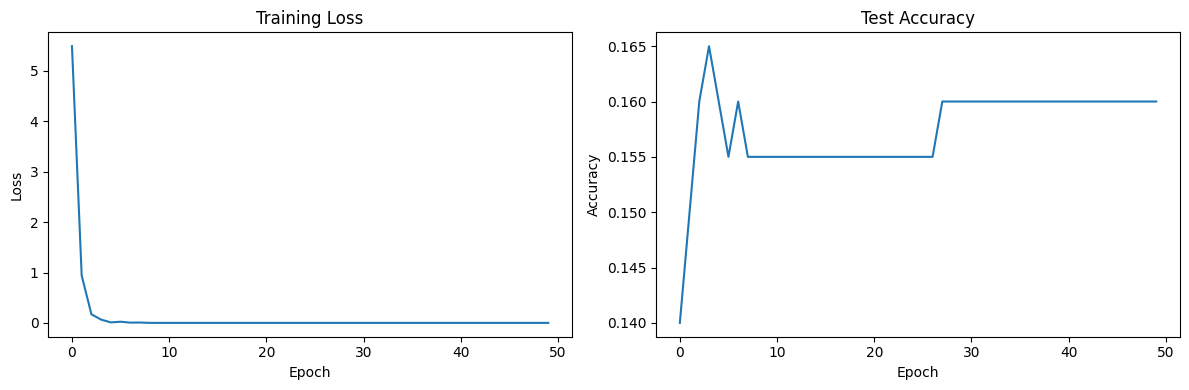

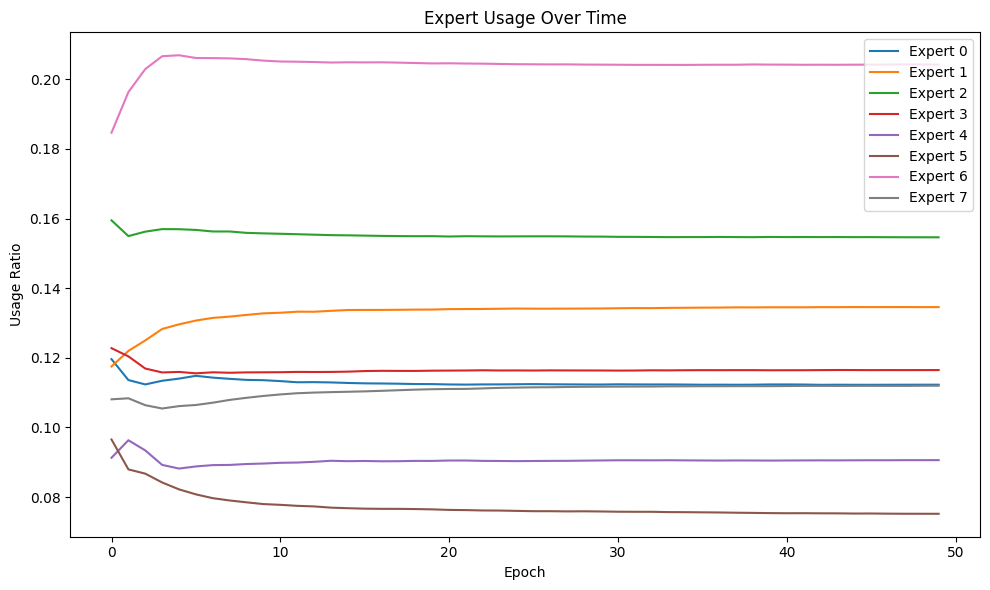

In [ ]:
# 导入必要的库
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# 使用提供的DynamicMoE和DynamicMoELoss类

# 创建一个小型测试数据集
X, y = make_classification(
    n_samples=1000,
    n_features=512,
    n_informative=400,
    n_classes=10,
    random_state=42
)
X = torch.FloatTensor(X)
y = torch.LongTensor(y)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建数据加载器
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

# 初始化模型
model = DynamicMoE(
    input_dim=512,
    num_experts=8,
    expert_hidden_dim=1024,
    output_dim=10,
    router_threshold=0.7,
    min_experts=1,
    max_experts=4
)

# 初始化损失函数和优化器
criterion = DynamicMoELoss(aux_weight=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
test_accuracies = []
expert_usage_history = []

for epoch in range(50):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets, model)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # 评估模型
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)
    
    # 记录专家使用情况
    expert_usage = model.get_expert_usage().cpu().numpy()
    expert_usage_history.append(expert_usage)
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {epoch_loss:.4f}, Test Acc: {test_accuracy:.4f}')
        print(f'Expert Usage: {expert_usage}')

# 绘制训练损失和测试准确率曲线
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('training_metrics.png')

# 绘制专家使用情况随时间的变化
plt.figure(figsize=(10, 6))
expert_usage_history = np.array(expert_usage_history)
for i in range(expert_usage_history.shape[1]):
    plt.plot(expert_usage_history[:, i], label=f'Expert {i}')
plt.title('Expert Usage Over Time')
plt.xlabel('Epoch')
plt.ylabel('Usage Ratio')
plt.legend()
plt.tight_layout()
plt.savefig('expert_usage.png')

# 测试不同复杂度输入的专家选择数量
complex_input = torch.randn(10, 512) * 5  # 高方差 = 更复杂
simple_input = torch.randn(10, 512) * 0.5  # 低方差 = 更简单

with torch.no_grad():
    complex_gates, _ = model.dynamic_router(complex_input.to(device))
    simple_gates, _ = model.dynamic_router(simple_input.to(device))
    
complex_expert_count = torch.sum(complex_gates > 1e-6, dim=1).cpu().numpy()
simple_expert_count = torch.sum(simple_gates > 1e-6, dim=1).cpu().numpy()

print(f"复杂输入平均激活专家数: {np.mean(complex_expert_count):.2f}")
print(f"简单输入平均激活专家数: {np.mean(simple_expert_count):.2f}")

# 测试专家容量控制
batch_size = 100
large_batch = torch.randn(batch_size, 512).to(device)
with torch.no_grad():
    gates, expert_load = model.dynamic_router(large_batch)
    expert_capacity = int(batch_size * model.capacity_factor)
    
print(f"专家容量: {expert_capacity}")
print(f"实际专家负载: {expert_load.cpu().numpy()}")    

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import Optional, List, Dict, Any

class LoRALayer:
    """LoRA层的基类，为线性层添加低秩适应功能"""
    def __init__(
        self, 
        r: int, 
        lora_alpha: int, 
        lora_dropout: float,
        merge_weights: bool
    ):
        self.r = r
        self.lora_alpha = lora_alpha
        self.lora_dropout = nn.Dropout(p=lora_dropout)
        self.merged = False
        self.merge_weights = merge_weights

class LoRALinear(nn.Linear, LoRALayer):
    """带LoRA的线性层"""
    def __init__(
        self, 
        in_features: int, 
        out_features: int,
        r: int = 0, 
        lora_alpha: int = 1, 
        lora_dropout: float = 0.,
        **kwargs
    ):
        nn.Linear.__init__(self, in_features, out_features, **kwargs)
        LoRALayer.__init__(self, r, lora_alpha, lora_dropout, False)
        
        if r > 0:
            self.lora_A = nn.Parameter(self.weight.new_zeros((r, in_features)))
            self.lora_B = nn.Parameter(self.weight.new_zeros((out_features, r)))
            self.scaling = self.lora_alpha / self.r
            self.weight.requires_grad = False
            nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
            nn.init.zeros_(self.lora_B)

    def forward(self, x: torch.Tensor):
        if self.r > 0 and not self.merged:
            result = F.linear(x, self.weight, bias=self.bias)
            if self.training and self.lora_dropout.p > 0:
                result += self.lora_dropout(x) @ (self.lora_B @ self.lora_A) * self.scaling
            else:
                result += (x @ (self.lora_B @ self.lora_A)) * self.scaling
            return result
        else:
            return F.linear(x, self.weight, bias=self.bias)

class Expert(nn.Module):
    """MMoE中的单个专家"""
    def __init__(self, in_features: int, hidden_size: int):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, hidden_size),
            nn.GELU()
        )
        
    def forward(self, x):
        return self.fc(x)

class DynamicGatingNetwork(nn.Module):
    """动态门控网络，根据输入调整专家权重"""
    def __init__(self, in_features: int, num_experts: int, num_tasks: int, hidden_size: int = 64):
        super().__init__()
        self.num_experts = num_experts
        self.num_tasks = num_tasks
        self.shared_layer = nn.Linear(in_features, hidden_size)
        self.gates = nn.ModuleList([
            nn.Linear(hidden_size, num_experts)
            for _ in range(num_tasks)
        ])
        self.adaptive_layer = nn.Linear(in_features, num_tasks * num_experts)

    def forward(self, x):
        shared_repr = F.relu(self.shared_layer(x))
        base_gates = [gate(shared_repr) for gate in self.gates]
        adaptive_weights = self.adaptive_layer(x).view(-1, self.num_tasks, self.num_experts)
        final_gates = []
        for i in range(self.num_tasks):
            task_gate = base_gates[i] + adaptive_weights[:, i, :]
            final_gates.append(F.softmax(task_gate, dim=-1))
        return final_gates

class DynamicMMoE(nn.Module):
    """动态多门混合专家模型"""
    def __init__(
        self, 
        in_features: int, 
        num_experts: int = 4, 
        num_tasks: int = 3,
        expert_hidden_size: Optional[int] = None,  # 改为可选参数
        gate_hidden_size: int = 64
    ):
        super().__init__()
        self.num_experts = num_experts
        self.num_tasks = num_tasks
        
        # 关键修改：默认专家输出维度与输入维度一致
        if expert_hidden_size is None:
            expert_hidden_size = in_features  # 与输入维度对齐
        
        self.experts = nn.ModuleList([
            Expert(in_features, expert_hidden_size)
            for _ in range(num_experts)
        ])
        
        self.gating = DynamicGatingNetwork(
            in_features, 
            num_experts, 
            num_tasks,
            gate_hidden_size
        )
        
        self.loss_weight = 0.01

    def forward(self, x):
        expert_outputs = [expert(x) for expert in self.experts]
        expert_outputs = torch.stack(expert_outputs, dim=1)
        
        gates = self.gating(x)
        task_outputs = []
        for i in range(self.num_tasks):
            expanded_gates = gates[i].unsqueeze(2).expand_as(expert_outputs)
            weighted_output = expert_outputs * expanded_gates
            task_output = torch.sum(weighted_output, dim=1)
            task_outputs.append(task_output)
        
        gates_tensor = torch.stack(gates, dim=1)
        importance = gates_tensor.mean(0).mean(0)
        load = torch.stack([(gates_tensor.argmax(2) == i).float().mean() for i in range(self.num_experts)])
        balance_loss = (importance * load).sum() * self.loss_weight
        
        return task_outputs, balance_loss

class BaseModel(nn.Module):
    """结合LoRA和动态MMoE的基模型"""
    def __init__(
        self,
        input_dim: int = 768,
        hidden_dim: int = 2048,
        num_tasks: int = 3,
        num_layers: int = 4,
        num_experts: int = 4,
        lora_r: int = 8,
        lora_alpha: int = 16
    ):
        super().__init__()
        
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.shared_layers = nn.ModuleList([
            LoRALinear(
                in_features=hidden_dim,
                out_features=hidden_dim,
                r=lora_r,
                lora_alpha=lora_alpha
            )
            for _ in range(num_layers // 2)
        ])
        
        # 关键修改：MMoE的输入维度是hidden_dim，专家输出维度也会自动设为hidden_dim
        self.mmoe_layer = DynamicMMoE(
            in_features=hidden_dim,  # 输入维度为hidden_dim
            num_experts=num_experts,
            num_tasks=num_tasks,
            # 不指定expert_hidden_size，自动与in_features（hidden_dim）对齐
        )
        
        # 任务输出层输入维度为hidden_dim（与专家输出一致）
        self.task_output_layers = nn.ModuleList([
            nn.Linear(hidden_dim, 1)
            for _ in range(num_tasks)
        ])
        
        self.act = nn.GELU()
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        x = self.act(self.norm(self.input_layer(x)))
        
        for layer in self.shared_layers:
            x = self.act(self.norm(layer(x)))
        
        task_reprs, balance_loss = self.mmoe_layer(x)
        
        task_outputs = [self.task_output_layers[i](task_reprs[i]) for i in range(len(task_reprs))]
        
        return task_outputs, balance_loss

def train_example():
    model = BaseModel(
        input_dim=768,
        hidden_dim=2048,
        num_tasks=3,
        num_layers=4,
        num_experts=4,
        lora_r=8,
        lora_alpha=16
    )
    
    optimizer = torch.optim.Adam(
        [p for n, p in model.named_parameters() if p.requires_grad],
        lr=1e-4
    )
    
    for epoch in range(10):
        inputs = torch.randn(32, 768)
        labels = [torch.randn(32, 1) for _ in range(3)]
        
        task_outputs, balance_loss = model(inputs)
        task_losses = [F.mse_loss(task_outputs[i], labels[i]) for i in range(3)]
        total_loss = sum(task_losses) + balance_loss
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        print(f"Epoch {epoch+1}, Total Loss: {total_loss.item():.4f}")

if __name__ == "__main__":
    train_example()

Epoch 1, Total Loss: 3.2442
Epoch 2, Total Loss: 3.0339
Epoch 3, Total Loss: 3.8106
Epoch 4, Total Loss: 3.5408
Epoch 5, Total Loss: 3.2263
Epoch 6, Total Loss: 3.1929
Epoch 7, Total Loss: 2.7240
Epoch 8, Total Loss: 3.2649
Epoch 9, Total Loss: 2.6452
Epoch 10, Total Loss: 2.5835


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import Optional, List, Dict, Any
from transformers import AutoModel, AutoConfig

import torch
print(torch.__version__)  # 应该输出版本号，如 2.0.1

# LoRA相关模块
class LoRALayer:
    """LoRA层的基类，为线性层添加低秩适应功能"""
    def __init__(
        self, 
        r: int, 
        lora_alpha: int, 
        lora_dropout: float,
        merge_weights: bool
    ):
        self.r = r
        self.lora_alpha = lora_alpha
        self.lora_dropout = nn.Dropout(p=lora_dropout)
        self.merged = False
        self.merge_weights = merge_weights

class LoRALinear(nn.Linear, LoRALayer):
    """带LoRA的线性层"""
    def __init__(
        self, 
        in_features: int, 
        out_features: int,
        r: int = 0, 
        lora_alpha: int = 1, 
        lora_dropout: float = 0.,
        **kwargs
    ):
        nn.Linear.__init__(self, in_features, out_features, **kwargs)
        LoRALayer.__init__(self, r, lora_alpha, lora_dropout, False)
        
        if r > 0:
            self.lora_A = nn.Parameter(self.weight.new_zeros((r, in_features)))
            self.lora_B = nn.Parameter(self.weight.new_zeros((out_features, r)))
            self.scaling = self.lora_alpha / self.r
            self.weight.requires_grad = False
            nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
            nn.init.zeros_(self.lora_B)

    def forward(self, x: torch.Tensor):
        if self.r > 0 and not self.merged:
            result = F.linear(x, self.weight, bias=self.bias)
            if self.training and self.lora_dropout.p > 0:
                result += self.lora_dropout(x) @ (self.lora_B @ self.lora_A) * self.scaling
            else:
                result += (x @ (self.lora_B @ self.lora_A)) * self.scaling
            return result
        else:
            return F.linear(x, self.weight, bias=self.bias)

# 动态MMoE相关模块
class Expert(nn.Module):
    """MMoE中的单个专家"""
    def __init__(self, in_features: int, hidden_size: int):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, hidden_size),
            nn.GELU()
        )
        
    def forward(self, x):
        return self.fc(x)

class DynamicGatingNetwork(nn.Module):
    """动态门控网络，根据输入调整专家权重"""
    def __init__(self, in_features: int, num_experts: int, num_tasks: int, hidden_size: int = 64):
        super().__init__()
        self.num_experts = num_experts
        self.num_tasks = num_tasks
        self.shared_layer = nn.Linear(in_features, hidden_size)
        self.gates = nn.ModuleList([
            nn.Linear(hidden_size, num_experts)
            for _ in range(num_tasks)
        ])
        self.adaptive_layer = nn.Linear(in_features, num_tasks * num_experts)

    def forward(self, x):
        shared_repr = F.relu(self.shared_layer(x))
        base_gates = [gate(shared_repr) for gate in self.gates]
        adaptive_weights = self.adaptive_layer(x).view(-1, self.num_tasks, self.num_experts)
        final_gates = []
        for i in range(self.num_tasks):
            task_gate = base_gates[i] + adaptive_weights[:, i, :]
            final_gates.append(F.softmax(task_gate, dim=-1))
        return final_gates

class DynamicMMoE(nn.Module):
    """动态多门混合专家模型"""
    def __init__(
        self, 
        in_features: int, 
        num_experts: int = 4, 
        num_tasks: int = 3,
        expert_hidden_size: Optional[int] = None,
        gate_hidden_size: int = 64
    ):
        super().__init__()
        self.num_experts = num_experts
        self.num_tasks = num_tasks
        
        if expert_hidden_size is None:
            expert_hidden_size = in_features
        
        self.experts = nn.ModuleList([
            Expert(in_features, expert_hidden_size)
            for _ in range(num_experts)
        ])
        
        self.gating = DynamicGatingNetwork(
            in_features, 
            num_experts, 
            num_tasks,
            gate_hidden_size
        )
        
        self.loss_weight = 0.01

    def forward(self, x):
        expert_outputs = [expert(x) for expert in self.experts]
        expert_outputs = torch.stack(expert_outputs, dim=1)
        
        gates = self.gating(x)
        task_outputs = []
        for i in range(self.num_tasks):
            expanded_gates = gates[i].unsqueeze(2).expand_as(expert_outputs)
            weighted_output = expert_outputs * expanded_gates
            task_output = torch.sum(weighted_output, dim=1)
            task_outputs.append(task_output)
        
        gates_tensor = torch.stack(gates, dim=1)
        importance = gates_tensor.mean(0).mean(0)
        load = torch.stack([(gates_tensor.argmax(2) == i).float().mean() for i in range(self.num_experts)])
        balance_loss = (importance * load).sum() * self.loss_weight
        
        return task_outputs, balance_loss

# 整合Hugging Face基模型的多任务模型
class HuggingFaceMultiTaskModel(nn.Module):
    """结合Hugging Face基模型、LoRA和动态MMoE的多任务模型"""
    def __init__(
        self,
        model_name: str = "bert-base-uncased",
        num_tasks: int = 3,
        num_experts: int = 4,
        lora_r: int = 8,
        lora_alpha: int = 16,
        lora_dropout: float = 0.1,
        add_lora_to: List[str] = ["key", "query", "value", "intermediate", "output"],
    ):
        super().__init__()
        
        # 加载Hugging Face预训练模型
        self.base_model = AutoModel.from_pretrained(model_name)
        config = AutoConfig.from_pretrained(model_name)
        self.hidden_size = config.hidden_size
        self.num_tasks = num_tasks
        
        # 为基模型的特定层添加LoRA
        self._add_lora_to_model(lora_r, lora_alpha, lora_dropout, add_lora_to)
        
        # 动态MMoE层
        self.mmoe_layer = DynamicMMoE(
            in_features=self.hidden_size,
            num_experts=num_experts,
            num_tasks=num_tasks
        )
        
        # 任务特定输出层
        self.task_output_layers = nn.ModuleList([
            nn.Linear(self.hidden_size, 1)  # 假设每个任务都是回归问题
            for _ in range(num_tasks)
        ])
        
        # 池化层（从基模型获取句子表示）
        self.pooler = nn.Linear(self.hidden_size, self.hidden_size)
        self.act = nn.Tanh()

    def _add_lora_to_model(self, r, lora_alpha, lora_dropout, add_lora_to):
        """为基模型的指定层添加LoRA"""
        for name, module in self.base_model.named_modules():
            if any(layer_type in name for layer_type in add_lora_to) and isinstance(module, nn.Linear):
                # 创建LoRA线性层替换原始线性层
                lora_module = LoRALinear(
                    in_features=module.in_features,
                    out_features=module.out_features,
                    r=r,
                    lora_alpha=lora_alpha,
                    lora_dropout=lora_dropout
                )
                # 复制原始权重
                lora_module.weight.data = module.weight.data
                if module.bias is not None:
                    lora_module.bias.data = module.bias.data
                
                # 替换模块
                parent_name, child_name = name.rsplit(".", 1)
                parent_module = self.base_model.get_submodule(parent_name)
                setattr(parent_module, child_name, lora_module)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        # 通过基模型获取表示
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        
        # 获取[CLS]标记的表示作为句子表示
        pooled_output = self.act(self.pooler(outputs.last_hidden_state[:, 0]))
        
        # 通过动态MMoE层
        task_reprs, balance_loss = self.mmoe_layer(pooled_output)
        
        # 每个任务的输出
        task_outputs = [self.task_output_layers[i](task_reprs[i]) for i in range(self.num_tasks)]
        
        return task_outputs, balance_loss

# 多任务训练示例
def train_example():
    # 初始化模型（使用BERT-base作为基模型）
    model = HuggingFaceMultiTaskModel(
        model_name="bert-base-uncased",
        num_tasks=3,  # 假设有3个任务
        num_experts=4,
        lora_r=8,
        lora_alpha=16,
        lora_dropout=0.1,
        add_lora_to=["key", "query", "value"]  # 只对注意力机制添加LoRA
    )
    
    # 冻结基模型的大部分参数，只训练LoRA和MMoE相关参数
    for name, param in model.named_parameters():
        if "lora" not in name and "mmoe" not in name and "task_output" not in name:
            param.requires_grad = False
    
    # 优化器 - 只训练LoRA参数、MMoE相关参数和任务输出层
    optimizer = torch.optim.Adam(
        [p for n, p in model.named_parameters() if p.requires_grad],
        lr=1e-4
    )
    
    # 模拟训练
    for epoch in range(10):
        # 生成随机输入和多任务标签
        input_ids = torch.randint(0, 30000, (32, 128))  # 批次大小32，序列长度128
        attention_mask = torch.ones(32, 128)
        labels = [torch.randn(32, 1) for _ in range(3)]  # 3个任务的标签
        
        # 前向传播
        task_outputs, balance_loss = model(input_ids, attention_mask)
        
        # 计算每个任务的损失
        task_losses = [F.mse_loss(task_outputs[i], labels[i]) for i in range(3)]
        
        # 总损失 = 任务损失之和 + MMoE负载均衡损失
        total_loss = sum(task_losses) + balance_loss
        
        # 反向传播和优化
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        print(f"Epoch {epoch+1}, Total Loss: {total_loss.item():.4f}")

if __name__ == "__main__":
    train_example()

1.9.0+cu111


ImportError: 
AutoModel requires the PyTorch library but it was not found in your environment. Check out the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Dict, Optional, Union
from transformers import AutoModel, AutoConfig, PreTrainedModel, PreTrainedTokenizerFast

# 动态门控网络
class DynamicGatingNetwork(nn.Module):
    """根据输入动态调整专家权重的门控网络"""
    def __init__(
        self, 
        input_dim: int, 
        num_experts: int, 
        num_tasks: int, 
        hidden_dim: int = 64
    ):
        super().__init__()
        self.num_experts = num_experts
        self.num_tasks = num_tasks
        
        # 共享底层
        self.shared_layer = nn.Linear(input_dim, hidden_dim)
        
        # 每个任务的门控网络
        self.gates = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, num_experts)
            )
            for _ in range(num_tasks)
        ])
        
        # 输入依赖的门控调整
        self.adaptive_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_tasks * num_experts)
        )

    def forward(self, inputs: torch.Tensor) -> List[torch.Tensor]:
        """
        计算每个任务的专家权重
        
        Args:
            inputs: 输入特征 [batch_size, input_dim]
            
        Returns:
            gates: 每个任务的专家权重列表，每个元素形状为 [batch_size, num_experts]
        """
        # 计算共享表示
        shared_repr = F.relu(self.shared_layer(inputs))
        
        # 基础门控权重
        base_gates = [gate(shared_repr) for gate in self.gates]
        
        # 输入依赖的门控调整
        adaptive_weights = self.adaptive_layer(inputs).view(-1, self.num_tasks, self.num_experts)
        
        # 组合基础门控和自适应调整
        final_gates = []
        for i in range(self.num_tasks):
            task_gate = base_gates[i] + adaptive_weights[:, i, :]
            final_gates.append(F.softmax(task_gate, dim=-1))
            
        return final_gates

# 专家网络
class Expert(nn.Module):
    """单个专家网络"""
    def __init__(self, input_dim: int, hidden_dim: int, dropout: float = 0.1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self.layers(inputs)

# 任务特定输出层
class TaskOutputLayer(nn.Module):
    """任务特定的输出层"""
    def __init__(self, input_dim: int, task_type: str, num_classes: int):
        super().__init__()
        self.task_type = task_type
        
        if task_type == "classification":
            self.output_layer = nn.Linear(input_dim, num_classes)
        elif task_type == "regression":
            self.output_layer = nn.Linear(input_dim, 1)
        elif task_type == "token_classification":
            self.output_layer = nn.Linear(input_dim, num_classes)
        else:
            raise ValueError(f"不支持的任务类型: {task_type}")
            
    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        if self.task_type == "token_classification":
            # 对于token级任务，保持序列维度
            return self.output_layer(inputs)
        else:
            # 对于句子级任务，取[CLS]标记的表示
            return self.output_layer(inputs[:, 0])

# 基于Hugging Face的动态MMoE多任务模型
class HuggingFaceDynamicMMoEModel(nn.Module):
    """结合Hugging Face预训练模型和动态MMoE的多任务学习模型"""
    def __init__(
        self,
        model_name: str = "bert-base-uncased",
        num_experts: int = 4,
        tasks: List[Dict[str, Union[str, int]]] = [
            {"name": "classification", "type": "classification", "num_classes": 2},
            {"name": "ner", "type": "token_classification", "num_classes": 5},
            {"name": "regression", "type": "regression", "num_classes": 1}
        ],
        expert_hidden_dim: int = 768,
        gate_hidden_dim: int = 64,
        dropout: float = 0.1,
        load_weights: bool = True,
        use_lora: bool = False,
        lora_r: int = 8,
        lora_alpha: int = 16
    ):
        super().__init__()
        
        # 加载预训练模型
        self.base_model = AutoModel.from_pretrained(model_name)
        config = AutoConfig.from_pretrained(model_name)
        self.hidden_dim = config.hidden_size
        self.tasks = tasks
        self.num_tasks = len(tasks)
        
        # 动态MMoE组件
        self.experts = nn.ModuleList([
            Expert(self.hidden_dim, expert_hidden_dim, dropout)
            for _ in range(num_experts)
        ])
        
        self.gating_network = DynamicGatingNetwork(
            input_dim=self.hidden_dim,
            num_experts=num_experts,
            num_tasks=self.num_tasks,
            hidden_dim=gate_hidden_dim
        )
        
        # 任务特定输出层
        self.task_output_layers = nn.ModuleList([
            TaskOutputLayer(
                input_dim=expert_hidden_dim,
                task_type=task["type"],
                num_classes=task["num_classes"]
            )
            for task in tasks
        ])
        
        # 负载均衡损失权重
        self.loss_weight = 0.01
        
        # LoRA支持（简化版）
        if use_lora:
            self._apply_lora(lora_r, lora_alpha)
            
    def _apply_lora(self, r: int, alpha: int):
        """为模型应用LoRA（低秩适应）"""
        # 注意：这是一个简化版的LoRA实现，实际应用中可能需要更复杂的处理
        from peft import get_peft_model, LoraConfig, TaskType
        
        lora_config = LoraConfig(
            task_type=TaskType.FEATURE_EXTRACTION,
            r=r,
            lora_alpha=alpha,
            lora_dropout=0.1,
            target_modules=["query", "key", "value"]  # 只对注意力机制应用LoRA
        )
        
        self.base_model = get_peft_model(self.base_model, lora_config)
            
    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor = None,
        token_type_ids: torch.Tensor = None,
        task_indices: Optional[List[int]] = None
    ) -> Dict[str, torch.Tensor]:
        """
        前向传播
        
        Args:
            input_ids: 输入token IDs [batch_size, seq_len]
            attention_mask: 注意力掩码 [batch_size, seq_len]
            token_type_ids: token类型ID [batch_size, seq_len]
            task_indices: 任务索引列表，如果提供，则只计算指定任务的输出
            
        Returns:
            outputs: 包含每个任务输出的字典
        """
        # 通过预训练模型获取表示
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        
        # 获取[CLS]标记的表示作为句子表示（用于门控网络）
        pooled_output = outputs.last_hidden_state[:, 0]  # [batch_size, hidden_dim]
        
        # 获取所有专家的输出
        expert_outputs = [expert(outputs.last_hidden_state) for expert in self.experts]
        expert_outputs = torch.stack(expert_outputs, dim=1)  # [batch_size, num_experts, seq_len, hidden_dim]
        
        # 获取门控权重
        gates = self.gating_network(pooled_output)  # 每个任务一个门控权重
        
        # 为每个任务计算输出
        task_outputs = {}
        for i, task in enumerate(self.tasks):
            if task_indices is not None and i not in task_indices:
                continue
                
            # 扩展门控权重以匹配专家输出维度
            expanded_gates = gates[i].unsqueeze(2).unsqueeze(2).expand_as(expert_outputs)
            
            # 加权组合专家输出
            weighted_output = expert_outputs * expanded_gates
            task_repr = torch.sum(weighted_output, dim=1)  # [batch_size, seq_len, hidden_dim]
            
            # 通过任务特定输出层
            task_output = self.task_output_layers[i](task_repr)
            task_outputs[task["name"]] = task_output
        
        # 计算负载均衡损失
        gates_tensor = torch.stack(gates, dim=1)  # [batch_size, num_tasks, num_experts]
        importance = gates_tensor.mean(0).mean(0)  # 专家重要性
        load = torch.stack([(gates_tensor.argmax(2) == i).float().mean() for i in range(len(self.experts))])
        balance_loss = (importance * load).sum() * self.loss_weight
        
        return {
            "task_outputs": task_outputs,
            "balance_loss": balance_loss
        }

# 训练示例
def train_multi_task_model():
    # 初始化模型
    model = HuggingFaceDynamicMMoEModel(
        model_name="bert-base-uncased",
        num_experts=4,
        tasks=[
            {"name": "sentiment", "type": "classification", "num_classes": 3},  # 情感分析
            {"name": "ner", "type": "token_classification", "num_classes": 5},  # 命名实体识别
            {"name": "regression", "type": "regression", "num_classes": 1}  # 文本评分
        ],
        use_lora=True,  # 使用LoRA进行参数高效微调
        lora_r=8,
        lora_alpha=16
    )
    
    # 优化器 - 只训练LoRA参数和MMoE相关参数
    optimizer = torch.optim.AdamW(
        [p for n, p in model.named_parameters() if p.requires_grad],
        lr=1e-4
    )
    
    # 假设我们有一个多任务数据集
    # 在实际应用中，应该使用真实数据集
    tokenizer = PreTrainedTokenizerFast.from_pretrained("bert-base-uncased")
    
    # 模拟训练
    model.train()
    for epoch in range(10):
        # 准备一批混合任务的数据
        # 注意：在实际应用中，需要适当组织多任务数据
        batch_size = 16
        
        # 示例输入
        texts = [
            "This movie is really amazing! I love it.",
            "Apple is planning to release a new iPhone next month.",
            "The stock market dropped significantly today due to economic concerns."
        ] * batch_size
        
        # 编码输入
        inputs = tokenizer(
            texts, 
            return_tensors="torch", 
            padding=True, 
            truncation=True, 
            max_length=128
        )
        
        # 模拟任务标签
        sentiment_labels = torch.randint(0, 3, (batch_size,))  # 情感标签
        ner_labels = torch.randint(0, 5, (batch_size, 128))  # NER标签
        regression_labels = torch.randn(batch_size, 1)  # 回归标签
        
        # 前向传播
        outputs = model(**inputs)
        
        # 计算每个任务的损失
        task_losses = {
            "sentiment": F.cross_entropy(
                outputs["task_outputs"]["sentiment"], 
                sentiment_labels
            ),
            "ner": F.cross_entropy(
                outputs["task_outputs"]["ner"].view(-1, 5), 
                ner_labels.view(-1)
            ),
            "regression": F.mse_loss(
                outputs["task_outputs"]["regression"], 
                regression_labels
            )
        }
        
        # 总损失 = 任务损失之和 + MMoE负载均衡损失
        total_loss = sum(task_losses.values()) + outputs["balance_loss"]
        
        # 反向传播和优化
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        print(f"Epoch {epoch+1}, Total Loss: {total_loss.item():.4f}")
        print(f"Task Losses: {', '.join([f'{k}: {v.item():.4f}' for k, v in task_losses.items()])}")

if __name__ == "__main__":
    train_multi_task_model()

Disabling PyTorch because PyTorch >= 2.1 is required but found 1.9.0+cu111
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


ImportError: 
AutoModel requires the PyTorch library but it was not found in your environment. Check out the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.
